<a href="https://colab.research.google.com/github/Tikquuss/GflowNets_Tutorial/blob/main/4_Sequence_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@Author TODO

**Generate multiples of $n$ (of maximum length less than $l > 2$)**

$$\mathcal{X} = [0, ...., 10^l-1]$$

The numbers are constructed autoregressively starting from an initial state (`[BOS]`, *Beginning Of Sentence*) and adding each time a digit between 0 and 9 at the end of the already constructed number. The process continues until a special symbol is generated (`[EOS]`, *End Of Sentence*) or until the number is of length $l$. As a reward function, we can decide to give a score of $1$ to the multiple of $n$, and a lower and lower score when the considered number is far from a multiple of $n$. A suitable reward function in this case is $R(x) = \lambda^ { - \beta \times min \{x-n*q_n(x) \text{, } n*(q_n(x)+1)-x \}}$ where $q_n(x)$ is the quotient of the Euclidean division of $x$ by $n$, $\lambda > 1$ and $\beta > 0$. The intuition behind this reward function is the following : a number $x$ is always surrounded by two multiples of another number $n$, $n*q_n(x) \le x < n*(q_n(x)+1)$. Among these two multiples, we choose the closest one to $x$, then we compute the distance $d = min \{x-n*q_n(x) \text{, } n*(q_n(x)+1)-x \}$ between it and this mutiple. To transform the distance into a reward, we just do $\lambda^{-d}, \ \lambda > 1$.

For example, if $n=5$, $\lambda = 2$ and $\beta = 1$ :
* Reward : 

$$R(x) = \left\{
    \begin{array}{ll}
        1 & \mbox{if } x = 5k \\
        2^{-1} & \mbox{if } x=5k+1 \mbox{ or } x=5k+4=5(k+1)-1 \\
        2^{-2} & \mbox{if } x=5k+2 \mbox{ or } x=5k+3=5(k+1)-2
    \end{array} \ \ \ \ \ \ \ \ \ \ (k \in \mathbb{N})
\right.$$

* Canonical partition function : $$Z = \sum_{x \in \mathcal{X}}R(x) = \sum_{x=0}^{10^l-1} R(x) $$

* Probability distribution : 

$$\pi(x) = \frac{R(x)}{Z} = \left\{
    \begin{array}{ll}
        \frac{1}{Z} & \mbox{if } x = 5k \\
        \frac{1}{2Z} & \mbox{if } x=5k+1 \mbox{ or } x=5k+4=5(k+1)-1 \\
        \frac{1}{4Z} & \mbox{if } x=5k+2 \mbox{ or } x=5k+3=5(k+1)-2
    \end{array} \ \ \ \ \ \ \ \ \ \ (k \in \mathbb{N})
\right.$$





In [1]:
import torch

In [2]:
def reward_function(x, a, lambda_ = 2, beta = 1, R_0 = 1e-6):
    q = x // a 
    return lambda_**-(beta*min(x-a*q, a*(q+1)-x)) + R_0 

def reward_function11(state, a, lambda_ = 2, beta = 1):
    """state : (bs, slen)"""
    r = torch.Tensor([reward_function(s, a, lambda_, beta) for s in [float("".join([str(s_i) for s_i in s])) for s in state.tolist()]])
    return r

def reward_function22(state, a, lambda_ = 2, beta = 1):
    """state : (bs, slen)"""
    r = torch.Tensor([reward_function(s, a, lambda_, beta) for s in state])
    return r

In [3]:
# n
#reward_coef = 5
#reward_coef = 11
reward_coef = 81

vocab = ["0", "1", "2", "3", "4", "5", "6", "7", "8", '9', '.', ','] # eos (.) and pad (,) tokens
pad_index = 10
eos_index = 10 + 1
bos_index = eos_index # we will use <EOS> as <BOS> (start token) everywhere 

vocab_size = len(vocab)
max_length = 4+1

lambda_ = 2
beta = 1

In [4]:
xs = torch.arange(0, int("".join(["9"]*max_length)))
all_rewards = reward_function22(xs, reward_coef, lambda_, beta)
print('total reward', all_rewards.view(-1).logsumexp(0))
true_dist = all_rewards.softmax(0).cpu().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


total reward tensor(11.5339)


In [5]:
tk = torch.tensor(all_rewards).topk(k=20)
modes = tk.indices
print(modes)
print(tk.values)

tensor([ 891,  567,  810, 1134,  243, 1053,  648, 1458,  324,  405, 1215,   81,
        1296,  972, 1377,  729, 1539,  486,  162,    0])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


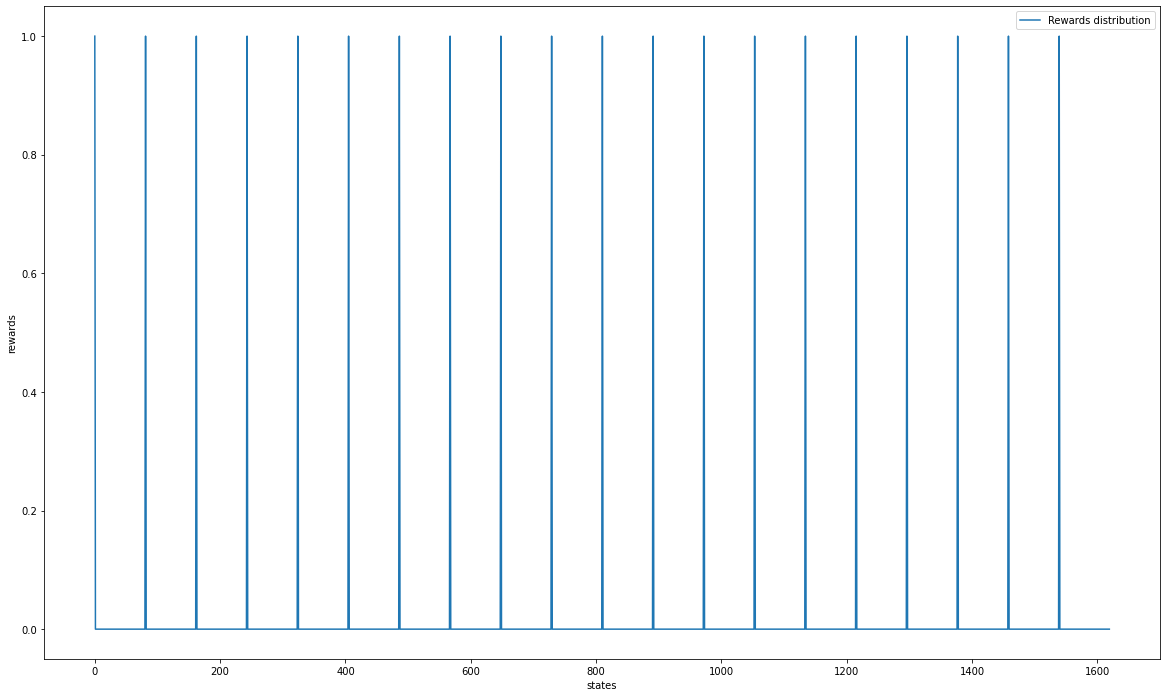

In [6]:
import matplotlib.pyplot as plt
figsize=(15+5,3*4)
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize = figsize)

# observe 20 modes
ax1.plot(xs[:20*reward_coef], all_rewards[:20*reward_coef], label="Rewards distribution")
ax1.set(xlabel='states', ylabel='rewards')
#ax1.set_title('...')
ax1.legend()

#### Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import itertools
import numpy as np

def Embedding(num_embeddings, embedding_dim, padding_idx=None):
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.normal_(m.weight, mean=0, std=embedding_dim ** -0.5)
    if padding_idx is not None:
        nn.init.constant_(m.weight[padding_idx], 0)
    return m

def get_padding_masks(slen, lengths):
    """
    Generate hidden states mask
    """
    assert lengths.max().item() <= slen
    bs = lengths.size(0)
    alen = torch.arange(slen, dtype=torch.long, device=lengths.device)
    mask = alen < lengths[:, None]
    # sanity check
    assert mask.size() == (bs, slen)
    return mask

class TransformerModel(nn.Module):

    # params : n_words, eos_index, pad_index, emb_dim

    def __init__(self, params, transformer_layers):
        """
        Transformer model 
        """
        super().__init__()
        # embeddings : one hot is better in this case
        self.embeddings = Embedding(params.n_words, params.emb_dim, padding_idx=params.pad_index)
        # This can be replace by transformer model from torch.nn, huggingface transoformer ...
        self.transformer = transformer_layers

    def forward(self, x, lengths):
        """
        Inputs:
            `x` LongTensor(bs, slen), containing word indices
            `lengths` LongTensor(bs), containing the length of each sentence
        """
        #padding_mask = x != self.pad_index
        #lengths = padding_mask.long().sum(dim=1).to(x.device)
        
        # check inputs
        bs, slen = x.size()
        assert lengths.size(0) == bs
        assert lengths.max().item() <= slen

        # generate masks
        mask = get_padding_masks(slen, lengths)

        # embeddings
        tensor = self.embeddings(x)
        tensor *= mask.unsqueeze(-1).to(tensor.dtype)
        
        # transformer layers
        tensor = self.transformer(tensor)
        
        return tensor

In [8]:
def make_mlp(l, act=nn.LeakyReLU(), tail=[]):
    """makes an MLP with no top layer activation"""
    return nn.Sequential(*(sum(
        [[nn.Linear(i, o)] + ([act] if n < len(l)-2 else [])
         for n, (i, o) in enumerate(zip(l, l[1:]))], []) + tail))

# Train

In [9]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
params = AttrDict({
    "n_words":vocab_size, 
    "pad_index" : pad_index, 
    "eos_index" : eos_index, 
    "bos_index" : bos_index,
    "emb_dim" : 100, 
})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
logZ = torch.zeros((1,)).to(device)

n_hid = 256
n_layers = 2

mlp = make_mlp([params.emb_dim] + [n_hid] * n_layers + [params.n_words]).to(device)
model = TransformerModel(params, mlp).to(device)
P_B = 1 # DAG & sequence generation => tree 


optim = torch.optim.Adam([ {'params':model .parameters(), 'lr':0.001}, {'params':[logZ], 'lr':0.01} ])
logZ.requires_grad_()

tensor([0.], requires_grad=True)

In [11]:
import tqdm

losses_TB = []
zs_TB = []
rewards_TB = []
all_visited_TB = []
first_visit_TB = -1 * np.ones_like(true_dist)
l1log_TB = []

**Here, we are dealing with trees (each non-initial sentence has only one parent), so $P_B = 1 \Rightarrow logP_B = 0$**

In [12]:
batch_size = 256
max_len = max_length + 0

#n_train_steps = 1000
n_train_steps = 5000

for it in tqdm.trange(n_train_steps):
    generated = torch.LongTensor(batch_size, max_len)  # upcoming output
    generated.fill_(params.pad_index)                  # fill upcoming ouput with <PAD>
    generated[:,0].fill_(params.bos_index)             # <BOS> (start token), initial state

    # Length of already generated sequences : 1 because of <BOS>
    #gen_len = (generated != params.pad_index).long().sum(dim=1)
    gen_len = torch.LongTensor(batch_size,).fill_(1) # (batch_size,)
    # 1 (True) if the generation of the sequence is not yet finished, 0 (False) otherwise
    unfinished_sents = gen_len.clone().fill_(1) # (batch_size,)
    # Length of already generated sequences : 1 because of <BOS>
    cur_len = 1 

    # Z_test = model(generated[:,:cur_len].to(device), lengths=gen_len.to(device))
    # #Z_test = Z_test[:,0].squeeze(1).exp().to(device)
    # Z_test = Z_test.sum(dim=1).squeeze(1).exp().to(device)
    # print(Z_test)

    Z = logZ.exp()

    flag = True
    if flag :
        # detached form  of TB
        ll_diff = torch.zeros((batch_size,)).to(device)
        ll_diff += logZ
    else :
        # non-detached form of TB ojective, where we multiply everything before doing the logarithm
        in_probs = torch.ones(batch_size, dtype=torch.float, requires_grad=True).to(device)

    while cur_len < max_len:
        state = generated[:,:cur_len] + 0 # (bs, cur_len)
        tensor = model(state.to(device), lengths=gen_len.to(device)) # (bs, cur_len, vocab_size)
        #scores = tensor[:,0] # (bs, vocab_size) : use last word for prediction
        scores = tensor.sum(dim=1) # (bs, vocab_size) 
        scores[:,pad_index] = -1e8 # we don't want to generate pad_token
        scores[:,eos_index] = -1e8 # if we don't want to generate eos_token : don't allow generation of sentences with differents lengths
        scores = scores.log_softmax(1)
        sample_temperature = 1
        probs = F.softmax(scores / sample_temperature, dim=1)
        next_words = torch.multinomial(probs, 1).squeeze(1)

        # update generations / lengths / finished sentences / current length
        generated[:,cur_len] = next_words.cpu() * unfinished_sents + params.pad_index * (1 - unfinished_sents)
        gen_len.add_(unfinished_sents) # add 1 to the length of the unfinished sentences
        unfinished_sents.mul_(next_words.cpu().ne(params.eos_index).long()) # as soon as we generate <EOS>, set unfinished_sents to 0
        cur_len = cur_len + 1

        # loss
        if flag :
            #sample_in_probs = probs.gather(1, next_words.unsqueeze(-1)).squeeze(1)
            #sample_in_probs[unfinished_sents == 0] = 1.
            #ll_diff += sample_in_probs.log()
            
            ll_diff += scores.gather(1, next_words.unsqueeze(-1)).squeeze(1)
        else :
            sample_in_probs = probs.gather(1, next_words.unsqueeze(-1)).squeeze(1)
            sample_in_probs[unfinished_sents == 0] = 1.
            in_probs = in_probs * sample_in_probs
      
        # stop when there is a <EOS> in each sentence, or if we exceed the maximul length
        if unfinished_sents.max() == 0:
            break

    generated = generated.apply_(lambda index : 0 if index == pad_index or index == eos_index else index)
    #R = reward_function(generated, reward_coef, lambda_, beta).to(device)
    generated =  [float("".join([str(s_i) for s_i in s])) for s in generated.tolist()]
    R = reward_function22(generated, reward_coef, lambda_, beta).to(device) 
    
    optim.zero_grad()
    if flag :
        ll_diff -= R.log()
        loss = (ll_diff**2).sum()/batch_size
    else :
        loss = ((Z*in_probs / R).log()**2).sum()/batch_size

    loss.backward()
    optim.step()

    losses_TB.append(loss.item())
    zs_TB.append(Z.item())
    rewards_TB.append(R.mean().cpu())
    all_visited_TB.extend(generated)
    for state in all_visited_TB :
        if first_visit_TB[int(state)]<0: first_visit_TB[int(state)] = it

    if it%100==0: 
        print('\nloss =', np.array(losses_TB[-100:]).mean(), 'Z =', Z.item(), "R =", np.array(rewards_TB[-100:]).mean() )
        emp_dist = np.bincount(all_visited_TB[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_TB.append((len(all_visited_TB), l1))
        print("gen", generated[-100:])

  0%|          | 4/5000 [00:00<04:24, 18.86it/s]


loss = 21.878496170043945 Z = 1.0 R = 0.039540775
L1 = 1.9950014187020977e-05
gen [3715.0, 597.0, 445.0, 1660.0, 8677.0, 1883.0, 715.0, 6515.0, 5162.0, 10.0, 5836.0, 5313.0, 5337.0, 5435.0, 4260.0, 5418.0, 1854.0, 961.0, 108.0, 2478.0, 2554.0, 9716.0, 6255.0, 5654.0, 1681.0, 6298.0, 55.0, 5195.0, 1685.0, 8574.0, 624.0, 5605.0, 3662.0, 8615.0, 3566.0, 1421.0, 5295.0, 5279.0, 8873.0, 5341.0, 6973.0, 8182.0, 5647.0, 7817.0, 9986.0, 2506.0, 4630.0, 1505.0, 2335.0, 4127.0, 7958.0, 7219.0, 3875.0, 9775.0, 9685.0, 5099.0, 1912.0, 1365.0, 3004.0, 2189.0, 8286.0, 4721.0, 8773.0, 8776.0, 2567.0, 6067.0, 7196.0, 6100.0, 7253.0, 3471.0, 8062.0, 152.0, 5584.0, 16.0, 4690.0, 5153.0, 4875.0, 8017.0, 7734.0, 1236.0, 3537.0, 6647.0, 6737.0, 1737.0, 5910.0, 6395.0, 8900.0, 4325.0, 707.0, 7158.0, 7967.0, 7925.0, 2566.0, 9637.0, 5538.0, 1395.0, 3977.0, 7353.0, 5698.0, 2565.0]


  2%|▏         | 102/5000 [00:07<08:25,  9.70it/s]


loss = 20.574343185424805 Z = 0.49576830863952637 R = 0.043126177
L1 = 1.820984172491732e-05
gen [9168.0, 2981.0, 7943.0, 859.0, 644.0, 461.0, 9580.0, 9129.0, 6672.0, 1240.0, 8992.0, 2989.0, 2959.0, 2991.0, 8919.0, 2999.0, 4677.0, 7643.0, 4291.0, 8998.0, 589.0, 9989.0, 1801.0, 3438.0, 1299.0, 4021.0, 4239.0, 8.0, 7757.0, 6290.0, 9438.0, 1680.0, 8898.0, 5602.0, 9383.0, 6612.0, 7314.0, 7216.0, 5939.0, 51.0, 2974.0, 7432.0, 7310.0, 2991.0, 1181.0, 4836.0, 8911.0, 5910.0, 7976.0, 1042.0, 1289.0, 9479.0, 2898.0, 89.0, 9428.0, 121.0, 8109.0, 8919.0, 9470.0, 8098.0, 4757.0, 7831.0, 4772.0, 7500.0, 7607.0, 4401.0, 7928.0, 4559.0, 7293.0, 8089.0, 5181.0, 7122.0, 6029.0, 292.0, 9809.0, 4216.0, 3529.0, 7771.0, 1426.0, 8194.0, 4949.0, 9307.0, 8111.0, 7241.0, 1506.0, 4150.0, 494.0, 3891.0, 2993.0, 6420.0, 4299.0, 4239.0, 2189.0, 810.0, 1421.0, 610.0, 8911.0, 1046.0, 7608.0, 9296.0]


  4%|▍         | 202/5000 [00:21<13:18,  6.01it/s]


loss = 10.548835225105286 Z = 1.8493107557296753 R = 0.44307336
L1 = 1.819215435535036e-05
gen [5911.0, 8910.0, 5991.0, 3808.0, 5912.0, 3808.0, 8991.0, 4212.0, 8913.0, 8992.0, 8914.0, 8993.0, 811.0, 891.0, 810.0, 7212.0, 4212.0, 5913.0, 5911.0, 7291.0, 8110.0, 3810.0, 8911.0, 8104.0, 5913.0, 5914.0, 5997.0, 7291.0, 4212.0, 810.0, 4212.0, 5914.0, 5114.0, 899.0, 7212.0, 8910.0, 7210.0, 8992.0, 8912.0, 8101.0, 4212.0, 8912.0, 8910.0, 5911.0, 8911.0, 3889.0, 8993.0, 3808.0, 3818.0, 8911.0, 3889.0, 810.0, 810.0, 3808.0, 5912.0, 8100.0, 8911.0, 5910.0, 1420.0, 811.0, 8910.0, 5110.0, 3808.0, 4212.0, 4212.0, 814.0, 891.0, 6424.0, 8999.0, 8101.0, 5193.0, 5914.0, 8991.0, 8913.0, 7292.0, 3808.0, 8110.0, 8911.0, 810.0, 8913.0, 4212.0, 7211.0, 3810.0, 5993.0, 5914.0, 8991.0, 891.0, 7291.0, 4212.0, 8912.0, 4210.0, 4213.0, 4212.0, 8991.0, 5914.0, 5911.0, 8913.0, 4212.0, 5991.0, 4212.0]


  6%|▌         | 301/5000 [00:41<17:10,  4.56it/s]


loss = 4.241723353862763 Z = 5.64068078994751 R = 0.5506681
L1 = 1.8194557103619444e-05
gen [811.0, 4292.0, 4212.0, 891.0, 4211.0, 4217.0, 4292.0, 8911.0, 5993.0, 4291.0, 3808.0, 3889.0, 3889.0, 7211.0, 4293.0, 4210.0, 4214.0, 8910.0, 5914.0, 5912.0, 4213.0, 810.0, 5991.0, 4212.0, 4210.0, 8912.0, 5997.0, 8912.0, 2997.0, 8991.0, 4210.0, 891.0, 7291.0, 3891.0, 3808.0, 5994.0, 2914.0, 891.0, 2913.0, 4291.0, 6810.0, 810.0, 5917.0, 5912.0, 3810.0, 5913.0, 8991.0, 5914.0, 2917.0, 5994.0, 8910.0, 891.0, 5993.0, 5912.0, 8993.0, 2911.0, 5993.0, 810.0, 8910.0, 5913.0, 7291.0, 8991.0, 8910.0, 1207.0, 1722.0, 3890.0, 3808.0, 2107.0, 8910.0, 5913.0, 5913.0, 810.0, 5993.0, 7291.0, 810.0, 8991.0, 8910.0, 891.0, 810.0, 8913.0, 8910.0, 5910.0, 7291.0, 8991.0, 4293.0, 3808.0, 5999.0, 810.0, 5912.0, 4213.0, 8910.0, 4210.0, 5914.0, 8910.0, 5913.0, 899.0, 889.0, 5992.0, 4212.0, 2917.0]


  8%|▊         | 401/5000 [01:06<23:24,  3.27it/s]


loss = 1.7745415925979615 Z = 11.362634658813477 R = 0.56908315
L1 = 1.82004519252554e-05
gen [5104.0, 4294.0, 8911.0, 5100.0, 810.0, 7210.0, 8911.0, 810.0, 5992.0, 8911.0, 8991.0, 4292.0, 2937.0, 8911.0, 8994.0, 5916.0, 8910.0, 5912.0, 5993.0, 5910.0, 5101.0, 891.0, 810.0, 810.0, 5910.0, 5912.0, 813.0, 7210.0, 2914.0, 3889.0, 5913.0, 8910.0, 2997.0, 5103.0, 891.0, 4291.0, 4213.0, 3889.0, 8099.0, 8910.0, 4210.0, 4210.0, 5107.0, 7211.0, 4292.0, 2917.0, 3808.0, 7291.0, 5993.0, 7294.0, 5913.0, 2997.0, 4293.0, 5917.0, 4212.0, 893.0, 7291.0, 5914.0, 811.0, 5912.0, 810.0, 5912.0, 8101.0, 4210.0, 891.0, 5913.0, 8913.0, 7210.0, 7210.0, 8100.0, 4292.0, 2914.0, 2997.0, 5101.0, 8100.0, 4292.0, 8991.0, 7291.0, 5913.0, 5911.0, 2913.0, 8101.0, 8101.0, 8910.0, 2997.0, 5104.0, 891.0, 5912.0, 8910.0, 5996.0, 3881.0, 5910.0, 5100.0, 2917.0, 3808.0, 5104.0, 891.0, 2917.0, 7211.0, 2911.0]


 10%|█         | 501/5000 [01:37<24:49,  3.02it/s]


loss = 0.9626963263750077 Z = 18.164836883544922 R = 0.5861866
L1 = 1.8280063741284536e-05
gen [5910.0, 4213.0, 6723.0, 894.0, 5912.0, 2996.0, 8991.0, 6726.0, 4210.0, 2914.0, 8910.0, 810.0, 2994.0, 2103.0, 893.0, 8992.0, 3808.0, 5911.0, 2993.0, 4292.0, 4292.0, 810.0, 5997.0, 5912.0, 3808.0, 4213.0, 4214.0, 2914.0, 5103.0, 7210.0, 2106.0, 2997.0, 4291.0, 2106.0, 5913.0, 7294.0, 8991.0, 4213.0, 810.0, 5993.0, 5101.0, 8991.0, 4291.0, 8913.0, 4292.0, 2996.0, 5913.0, 1207.0, 3808.0, 8993.0, 7210.0, 2996.0, 4293.0, 8910.0, 8991.0, 5916.0, 2107.0, 5993.0, 4214.0, 810.0, 8100.0, 6727.0, 5992.0, 7212.0, 810.0, 5913.0, 2107.0, 5994.0, 3808.0, 8101.0, 2917.0, 8106.0, 4214.0, 2106.0, 8101.0, 5994.0, 8100.0, 4212.0, 2997.0, 4293.0, 5093.0, 4296.0, 2994.0, 811.0, 4294.0, 3891.0, 4214.0, 810.0, 8100.0, 3808.0, 4293.0, 2917.0, 2106.0, 8100.0, 5912.0, 894.0, 8100.0, 2916.0, 7213.0, 4294.0]


 12%|█▏        | 601/5000 [02:13<30:54,  2.37it/s]


loss = 0.5940715411305427 Z = 24.709726333618164 R = 0.5930637
L1 = 1.8333445383286203e-05
gen [2996.0, 5100.0, 8992.0, 8102.0, 4294.0, 4291.0, 2916.0, 5910.0, 5103.0, 8100.0, 8912.0, 8911.0, 8910.0, 810.0, 4293.0, 4294.0, 2916.0, 8994.0, 3808.0, 891.0, 2916.0, 6726.0, 2104.0, 5994.0, 3808.0, 2108.0, 7291.0, 4296.0, 5911.0, 4213.0, 891.0, 4210.0, 4214.0, 8104.0, 4212.0, 5917.0, 891.0, 4213.0, 810.0, 7212.0, 6723.0, 4294.0, 5996.0, 4210.0, 4219.0, 812.0, 811.0, 4296.0, 5103.0, 7210.0, 2917.0, 2916.0, 2911.0, 5913.0, 8994.0, 5913.0, 8910.0, 4210.0, 4211.0, 5102.0, 894.0, 5993.0, 2914.0, 4213.0, 4212.0, 4214.0, 3808.0, 8100.0, 7210.0, 4293.0, 2107.0, 7291.0, 5913.0, 8912.0, 8910.0, 7210.0, 4213.0, 7211.0, 2914.0, 7291.0, 4294.0, 8102.0, 4291.0, 810.0, 4210.0, 811.0, 7210.0, 2916.0, 2106.0, 893.0, 8999.0, 2996.0, 4210.0, 4291.0, 8100.0, 7292.0, 5103.0, 4293.0, 5913.0, 7291.0]


 14%|█▍        | 701/5000 [03:01<32:02,  2.24it/s]


loss = 0.36823804162442686 Z = 29.536781311035156 R = 0.59072256
L1 = 1.8372653677013844e-05
gen [6724.0, 2997.0, 2917.0, 2913.0, 811.0, 891.0, 2996.0, 6724.0, 8914.0, 2106.0, 5992.0, 4294.0, 810.0, 8992.0, 894.0, 5914.0, 4296.0, 2916.0, 4294.0, 4214.0, 5103.0, 810.0, 3808.0, 5102.0, 3899.0, 6723.0, 5105.0, 2107.0, 8911.0, 5913.0, 4213.0, 8913.0, 7291.0, 5994.0, 4292.0, 4213.0, 2107.0, 4292.0, 2916.0, 5911.0, 891.0, 5913.0, 4210.0, 892.0, 5916.0, 8992.0, 8910.0, 813.0, 5912.0, 8100.0, 813.0, 4213.0, 2916.0, 8914.0, 8910.0, 810.0, 6724.0, 8911.0, 5911.0, 5994.0, 5102.0, 4212.0, 2917.0, 7210.0, 2107.0, 3808.0, 5994.0, 2916.0, 2105.0, 8104.0, 8913.0, 6721.0, 7211.0, 812.0, 2997.0, 8101.0, 2917.0, 4294.0, 893.0, 5914.0, 7210.0, 5914.0, 4213.0, 2104.0, 2915.0, 2914.0, 8910.0, 2915.0, 5912.0, 899.0, 4212.0, 5910.0, 7210.0, 5104.0, 6722.0, 2104.0, 2997.0, 8101.0, 6723.0, 8910.0]


 16%|█▌        | 801/5000 [03:49<35:39,  1.96it/s]


loss = 0.31608397349715234 Z = 32.087520599365234 R = 0.5884774
L1 = 1.8564836035198123e-05
gen [2916.0, 2997.0, 5912.0, 4213.0, 2107.0, 4292.0, 2915.0, 8991.0, 893.0, 5913.0, 814.0, 6722.0, 8912.0, 6722.0, 8910.0, 3881.0, 7210.0, 4294.0, 7210.0, 5915.0, 810.0, 5103.0, 5913.0, 2103.0, 810.0, 8910.0, 4292.0, 2997.0, 7294.0, 4215.0, 5994.0, 7292.0, 5916.0, 2916.0, 813.0, 8910.0, 3889.0, 2110.0, 2106.0, 5994.0, 6723.0, 6723.0, 8992.0, 3808.0, 8102.0, 8991.0, 6724.0, 5913.0, 5913.0, 4292.0, 810.0, 5912.0, 4213.0, 2917.0, 2913.0, 5993.0, 5913.0, 7212.0, 4213.0, 6724.0, 810.0, 5916.0, 5913.0, 6724.0, 7211.0, 6724.0, 6722.0, 6722.0, 1720.0, 811.0, 4293.0, 7210.0, 5994.0, 5105.0, 7292.0, 5917.0, 2996.0, 812.0, 4213.0, 8104.0, 811.0, 2996.0, 2106.0, 4212.0, 8100.0, 8992.0, 3808.0, 4213.0, 2915.0, 810.0, 8100.0, 3889.0, 8100.0, 6726.0, 8102.0, 2915.0, 2997.0, 4212.0, 4291.0, 4294.0]


 18%|█▊        | 901/5000 [04:47<38:40,  1.77it/s]


loss = 0.26135119907557963 Z = 33.8514289855957 R = 0.58071417
L1 = 1.9846296529283363e-05
gen [4293.0, 2997.0, 5993.0, 3889.0, 2916.0, 4293.0, 5110.0, 8910.0, 2911.0, 5105.0, 811.0, 2915.0, 3889.0, 7210.0, 5915.0, 813.0, 5993.0, 2106.0, 2997.0, 5102.0, 5103.0, 6723.0, 6724.0, 893.0, 5913.0, 5914.0, 2913.0, 899.0, 4210.0, 2107.0, 8100.0, 5913.0, 6722.0, 5993.0, 892.0, 2106.0, 5103.0, 810.0, 4293.0, 2994.0, 5912.0, 5993.0, 2917.0, 2915.0, 6723.0, 8100.0, 4292.0, 4214.0, 8991.0, 5102.0, 892.0, 2914.0, 810.0, 6725.0, 2915.0, 5997.0, 4294.0, 5995.0, 2915.0, 2993.0, 3889.0, 8102.0, 2917.0, 5994.0, 8910.0, 6723.0, 8910.0, 8101.0, 812.0, 8995.0, 5996.0, 810.0, 891.0, 6722.0, 6724.0, 8102.0, 2997.0, 2917.0, 5913.0, 5914.0, 2997.0, 5912.0, 2106.0, 8911.0, 2105.0, 5104.0, 2994.0, 5913.0, 4292.0, 6722.0, 5910.0, 8910.0, 7212.0, 8992.0, 2916.0, 6722.0, 8994.0, 810.0, 4213.0, 5913.0]


 20%|██        | 1001/5000 [05:48<41:41,  1.60it/s]


loss = 0.2563981212675571 Z = 34.5332145690918 R = 0.5776498
L1 = 1.9908362332270158e-05
gen [8910.0, 2107.0, 2917.0, 5103.0, 810.0, 5104.0, 2106.0, 4212.0, 7210.0, 5912.0, 8991.0, 4293.0, 6724.0, 8999.0, 5105.0, 5994.0, 2916.0, 8910.0, 7296.0, 5995.0, 891.0, 5101.0, 7211.0, 810.0, 5910.0, 5913.0, 2917.0, 5994.0, 4292.0, 2916.0, 7210.0, 2994.0, 8100.0, 2917.0, 2996.0, 5913.0, 4214.0, 8100.0, 812.0, 892.0, 893.0, 5993.0, 4293.0, 5911.0, 5912.0, 4212.0, 5914.0, 810.0, 5101.0, 8993.0, 6723.0, 7211.0, 891.0, 8101.0, 8103.0, 2997.0, 5912.0, 893.0, 8991.0, 8100.0, 8100.0, 6720.0, 2105.0, 8100.0, 810.0, 3899.0, 810.0, 3892.0, 892.0, 2915.0, 4293.0, 892.0, 8999.0, 2105.0, 5993.0, 5911.0, 4215.0, 8100.0, 2997.0, 2997.0, 4292.0, 4213.0, 4215.0, 4213.0, 891.0, 5997.0, 810.0, 8910.0, 2915.0, 5994.0, 6723.0, 2105.0, 5914.0, 2997.0, 1206.0, 6721.0, 2916.0, 5916.0, 8100.0, 2997.0]


 22%|██▏       | 1101/5000 [06:53<43:14,  1.50it/s]


loss = 0.2443750910460949 Z = 34.717979431152344 R = 0.57578444
L1 = 1.992004232301745e-05
gen [5911.0, 4299.0, 4292.0, 8911.0, 5913.0, 5913.0, 893.0, 6724.0, 5913.0, 889.0, 2916.0, 5912.0, 8991.0, 2105.0, 8100.0, 7210.0, 5995.0, 8912.0, 8101.0, 2108.0, 2993.0, 5991.0, 7292.0, 5911.0, 2997.0, 5104.0, 891.0, 5912.0, 8100.0, 8102.0, 812.0, 2916.0, 2110.0, 2110.0, 4210.0, 7299.0, 4212.0, 8910.0, 811.0, 8991.0, 813.0, 8100.0, 4211.0, 6721.0, 5996.0, 5914.0, 2916.0, 5991.0, 5993.0, 810.0, 4213.0, 8911.0, 4211.0, 4214.0, 2997.0, 5996.0, 4296.0, 5104.0, 891.0, 4214.0, 5104.0, 5995.0, 4296.0, 8912.0, 8101.0, 8913.0, 8996.0, 5104.0, 7210.0, 6724.0, 811.0, 4210.0, 4211.0, 4295.0, 4291.0, 8101.0, 8910.0, 8100.0, 4293.0, 8102.0, 4293.0, 8912.0, 8912.0, 2108.0, 5995.0, 3889.0, 7210.0, 6724.0, 8100.0, 7292.0, 2106.0, 6722.0, 813.0, 811.0, 5994.0, 4216.0, 5106.0, 4214.0, 2917.0, 5104.0]


 24%|██▍       | 1201/5000 [08:03<45:39,  1.39it/s]


loss = 0.23677451677620412 Z = 34.776451110839844 R = 0.5741545
L1 = 1.992826263196334e-05
gen [3889.0, 2916.0, 811.0, 4210.0, 8912.0, 8993.0, 889.0, 5994.0, 2916.0, 3808.0, 2917.0, 5913.0, 2997.0, 4292.0, 4213.0, 5101.0, 8100.0, 5914.0, 5913.0, 5914.0, 4210.0, 8913.0, 5993.0, 2105.0, 2997.0, 4213.0, 2105.0, 2917.0, 6723.0, 810.0, 4216.0, 6725.0, 2916.0, 3808.0, 5915.0, 891.0, 6726.0, 4214.0, 5103.0, 2107.0, 5103.0, 7291.0, 8997.0, 6724.0, 2916.0, 5993.0, 4296.0, 4291.0, 4294.0, 4212.0, 8912.0, 4215.0, 2106.0, 5103.0, 8992.0, 4294.0, 4215.0, 5994.0, 6722.0, 7293.0, 5103.0, 2916.0, 6723.0, 3808.0, 5994.0, 2106.0, 810.0, 2997.0, 4294.0, 7291.0, 4213.0, 7212.0, 811.0, 2916.0, 2917.0, 2107.0, 5103.0, 2916.0, 8910.0, 8992.0, 5996.0, 5912.0, 5103.0, 4216.0, 8994.0, 7291.0, 5912.0, 4212.0, 891.0, 6723.0, 7212.0, 5913.0, 3891.0, 811.0, 5993.0, 2916.0, 3891.0, 810.0, 891.0, 4213.0]


 26%|██▌       | 1301/5000 [09:17<47:36,  1.30it/s]


loss = 0.20350575767457485 Z = 34.946571350097656 R = 0.5789097
L1 = 1.9935629799339096e-05
gen [4213.0, 2105.0, 5913.0, 2105.0, 8911.0, 5914.0, 8995.0, 4293.0, 5994.0, 8100.0, 812.0, 4212.0, 4292.0, 810.0, 5913.0, 2913.0, 5106.0, 8912.0, 810.0, 5915.0, 7292.0, 3808.0, 5102.0, 4294.0, 2916.0, 5912.0, 2108.0, 2105.0, 2106.0, 6723.0, 2915.0, 6725.0, 8999.0, 8100.0, 5994.0, 5101.0, 5994.0, 6722.0, 2104.0, 894.0, 2108.0, 5916.0, 5994.0, 7210.0, 5995.0, 8103.0, 6723.0, 8993.0, 4293.0, 3898.0, 4291.0, 4214.0, 7210.0, 5995.0, 2915.0, 6721.0, 4293.0, 5103.0, 7294.0, 2995.0, 8101.0, 2915.0, 8911.0, 5993.0, 2106.0, 4291.0, 6724.0, 7210.0, 4291.0, 8100.0, 2916.0, 5912.0, 2996.0, 2917.0, 8910.0, 8100.0, 5912.0, 4214.0, 2916.0, 5996.0, 5102.0, 2996.0, 889.0, 5102.0, 2915.0, 2997.0, 811.0, 4293.0, 5911.0, 6721.0, 2915.0, 6726.0, 811.0, 8092.0, 8911.0, 4212.0, 8100.0, 5103.0, 5101.0, 8913.0]


 28%|██▊       | 1401/5000 [10:38<49:46,  1.20it/s]


loss = 0.218328110948205 Z = 35.07871627807617 R = 0.57449865
L1 = 1.993926338252697e-05
gen [2915.0, 812.0, 8913.0, 3808.0, 5103.0, 2916.0, 4213.0, 2996.0, 2997.0, 2916.0, 811.0, 6723.0, 2110.0, 812.0, 4212.0, 8991.0, 4212.0, 2916.0, 5911.0, 5991.0, 8991.0, 8100.0, 2105.0, 2997.0, 4294.0, 2107.0, 6722.0, 8911.0, 2996.0, 5996.0, 4210.0, 5913.0, 4211.0, 5994.0, 3889.0, 4212.0, 2997.0, 891.0, 6725.0, 8910.0, 891.0, 7210.0, 2914.0, 2105.0, 8991.0, 4213.0, 5914.0, 5102.0, 4292.0, 891.0, 5101.0, 8991.0, 811.0, 4293.0, 3892.0, 4292.0, 5103.0, 6724.0, 4211.0, 7294.0, 2997.0, 811.0, 5993.0, 6722.0, 899.0, 891.0, 4213.0, 4294.0, 4295.0, 8991.0, 4292.0, 2997.0, 813.0, 8102.0, 8911.0, 5106.0, 2106.0, 3899.0, 4294.0, 2916.0, 5994.0, 2993.0, 4211.0, 5103.0, 8911.0, 4293.0, 892.0, 4211.0, 2917.0, 5994.0, 4293.0, 8991.0, 8994.0, 4294.0, 2916.0, 6724.0, 4292.0, 4210.0, 7211.0, 2917.0]


 30%|███       | 1501/5000 [12:04<52:44,  1.11it/s]


loss = 0.2184767634421587 Z = 35.06538772583008 R = 0.5766609
L1 = 1.9942021876894437e-05
gen [811.0, 8993.0, 5102.0, 7212.0, 4294.0, 5913.0, 8100.0, 810.0, 5913.0, 8992.0, 6723.0, 5995.0, 2916.0, 2101.0, 4212.0, 3891.0, 2917.0, 4213.0, 4213.0, 5999.0, 6723.0, 2995.0, 4293.0, 810.0, 4292.0, 8910.0, 5913.0, 5993.0, 8994.0, 8992.0, 4212.0, 5913.0, 4215.0, 6723.0, 4295.0, 2913.0, 8910.0, 5993.0, 8991.0, 811.0, 899.0, 5996.0, 2106.0, 6723.0, 889.0, 5993.0, 5993.0, 8991.0, 3810.0, 5916.0, 5993.0, 8910.0, 5994.0, 2996.0, 891.0, 6722.0, 2916.0, 3808.0, 5994.0, 2106.0, 2997.0, 6723.0, 5912.0, 5913.0, 2106.0, 810.0, 7299.0, 811.0, 2916.0, 2996.0, 6722.0, 5993.0, 810.0, 4213.0, 4294.0, 6723.0, 810.0, 8101.0, 3810.0, 8910.0, 6722.0, 2917.0, 8910.0, 5102.0, 5994.0, 6722.0, 5912.0, 2105.0, 5993.0, 3810.0, 4294.0, 5103.0, 893.0, 2106.0, 8100.0, 4292.0, 7292.0, 2916.0, 3808.0, 5994.0]


 32%|███▏      | 1601/5000 [13:35<53:19,  1.06it/s]


loss = 0.21391601338982583 Z = 34.80195617675781 R = 0.5827158
L1 = 1.9944080364261836e-05
gen [5914.0, 2105.0, 4213.0, 4215.0, 6723.0, 2916.0, 5104.0, 6724.0, 5991.0, 8102.0, 2916.0, 5994.0, 8102.0, 2106.0, 2107.0, 5103.0, 7211.0, 8913.0, 811.0, 8911.0, 6729.0, 4291.0, 4294.0, 6723.0, 8910.0, 5993.0, 4292.0, 6723.0, 5995.0, 8101.0, 2913.0, 5916.0, 5104.0, 5106.0, 7210.0, 6721.0, 5994.0, 2106.0, 6721.0, 8910.0, 5913.0, 810.0, 2916.0, 4292.0, 8991.0, 7294.0, 2913.0, 8100.0, 5992.0, 6723.0, 8100.0, 6723.0, 6722.0, 6721.0, 4293.0, 2916.0, 2108.0, 811.0, 5100.0, 2916.0, 893.0, 4292.0, 8911.0, 2915.0, 5910.0, 4296.0, 4212.0, 6721.0, 5914.0, 5994.0, 2997.0, 4211.0, 8913.0, 4296.0, 2107.0, 812.0, 2916.0, 8911.0, 8101.0, 4292.0, 2916.0, 6724.0, 8100.0, 5103.0, 5107.0, 6724.0, 4292.0, 5100.0, 810.0, 811.0, 2107.0, 8101.0, 4210.0, 4213.0, 4213.0, 4211.0, 5103.0, 2106.0, 2996.0, 2106.0]


 34%|███▍      | 1701/5000 [15:12<54:36,  1.01it/s]


loss = 0.20267594054341317 Z = 34.94192123413086 R = 0.58147216
L1 = 1.994477206453534e-05
gen [4293.0, 4212.0, 891.0, 8100.0, 8910.0, 8910.0, 891.0, 8991.0, 4212.0, 2996.0, 7210.0, 5992.0, 3889.0, 2917.0, 892.0, 8910.0, 894.0, 4212.0, 2101.0, 4213.0, 891.0, 2913.0, 6721.0, 5910.0, 2917.0, 8911.0, 2916.0, 810.0, 810.0, 810.0, 4293.0, 5105.0, 2913.0, 6723.0, 5103.0, 810.0, 5994.0, 8102.0, 8100.0, 5995.0, 4295.0, 5104.0, 5913.0, 4292.0, 2107.0, 2107.0, 2994.0, 8910.0, 5916.0, 4293.0, 891.0, 6724.0, 810.0, 6723.0, 4294.0, 3808.0, 2914.0, 4296.0, 4215.0, 4293.0, 5101.0, 2108.0, 8991.0, 8100.0, 8999.0, 8101.0, 2916.0, 8910.0, 891.0, 8913.0, 8991.0, 5913.0, 5913.0, 6723.0, 8910.0, 8910.0, 5993.0, 810.0, 7210.0, 810.0, 3808.0, 2103.0, 7291.0, 6729.0, 2995.0, 5993.0, 891.0, 5103.0, 2997.0, 4215.0, 5991.0, 2915.0, 5991.0, 2915.0, 4295.0, 8991.0, 893.0, 6722.0, 5102.0, 7293.0]


 36%|███▌      | 1801/5000 [16:54<55:58,  1.05s/it]


loss = 0.19319876939058303 Z = 35.065711975097656 R = 0.5751135
L1 = 1.9944967913172084e-05
gen [8910.0, 2996.0, 2107.0, 8910.0, 8100.0, 2107.0, 4293.0, 5910.0, 8910.0, 4215.0, 4294.0, 5914.0, 2997.0, 5913.0, 892.0, 3808.0, 2108.0, 4293.0, 4293.0, 8992.0, 6720.0, 2106.0, 892.0, 4294.0, 3808.0, 2916.0, 891.0, 810.0, 5912.0, 8996.0, 5102.0, 4211.0, 5913.0, 8912.0, 2916.0, 4293.0, 4296.0, 5912.0, 4211.0, 5103.0, 3889.0, 6721.0, 5999.0, 4292.0, 8910.0, 5914.0, 2915.0, 8100.0, 810.0, 2105.0, 5994.0, 6722.0, 5996.0, 5913.0, 6724.0, 3889.0, 7210.0, 5914.0, 5915.0, 5994.0, 5912.0, 5993.0, 5914.0, 8100.0, 8910.0, 2915.0, 2108.0, 8999.0, 2911.0, 810.0, 4299.0, 5105.0, 5912.0, 818.0, 8994.0, 3808.0, 2106.0, 8992.0, 8993.0, 5993.0, 2916.0, 6723.0, 2106.0, 6725.0, 5914.0, 4292.0, 6726.0, 3889.0, 2106.0, 8101.0, 2915.0, 2995.0, 812.0, 893.0, 5106.0, 3889.0, 8910.0, 5912.0, 5915.0, 5102.0]


 38%|███▊      | 1901/5000 [18:42<56:59,  1.10s/it]


loss = 0.24351130485534667 Z = 34.676143646240234 R = 0.5812466
L1 = 1.9945063760808814e-05
gen [8910.0, 8991.0, 5105.0, 5101.0, 810.0, 5911.0, 2916.0, 2995.0, 5913.0, 8910.0, 2997.0, 8991.0, 7213.0, 8993.0, 6720.0, 5913.0, 2916.0, 4212.0, 3889.0, 4294.0, 6724.0, 7210.0, 5911.0, 4293.0, 8100.0, 6727.0, 5911.0, 8101.0, 2915.0, 8910.0, 5995.0, 6723.0, 5913.0, 2108.0, 8100.0, 6723.0, 6724.0, 2108.0, 6722.0, 4211.0, 2916.0, 3808.0, 2105.0, 2105.0, 5911.0, 5104.0, 5996.0, 8911.0, 2107.0, 2106.0, 5912.0, 8991.0, 5102.0, 810.0, 2913.0, 893.0, 6724.0, 8991.0, 2915.0, 896.0, 8992.0, 6726.0, 5994.0, 5915.0, 2915.0, 5914.0, 8910.0, 5102.0, 2997.0, 811.0, 4212.0, 4295.0, 4211.0, 2914.0, 814.0, 2913.0, 5105.0, 6722.0, 8911.0, 4212.0, 5916.0, 4215.0, 2106.0, 8910.0, 896.0, 5104.0, 5103.0, 5102.0, 2917.0, 2917.0, 7211.0, 4213.0, 6723.0, 6723.0, 3889.0, 5911.0, 2106.0, 5913.0, 5103.0, 7210.0]


 40%|████      | 2001/5000 [20:36<58:24,  1.17s/it]


loss = 0.2288556669652462 Z = 34.91728210449219 R = 0.57742214
L1 = 1.9944935546418435e-05
gen [4295.0, 2913.0, 5993.0, 7291.0, 8993.0, 6724.0, 2997.0, 2107.0, 8101.0, 8992.0, 5103.0, 8993.0, 2997.0, 5103.0, 810.0, 5996.0, 8102.0, 5103.0, 4293.0, 8102.0, 2106.0, 5995.0, 6722.0, 8999.0, 2916.0, 2914.0, 5995.0, 3810.0, 8100.0, 2997.0, 7292.0, 810.0, 8910.0, 812.0, 5997.0, 811.0, 891.0, 8910.0, 5912.0, 8100.0, 6725.0, 4213.0, 2106.0, 812.0, 4212.0, 7293.0, 2997.0, 8993.0, 4297.0, 6726.0, 5994.0, 2106.0, 5104.0, 2105.0, 893.0, 5991.0, 891.0, 5913.0, 889.0, 8991.0, 3808.0, 5103.0, 3808.0, 8991.0, 5994.0, 5103.0, 2916.0, 5104.0, 6723.0, 2914.0, 2996.0, 8910.0, 8911.0, 2916.0, 2916.0, 5915.0, 5914.0, 8999.0, 3808.0, 5102.0, 6723.0, 8100.0, 5993.0, 6727.0, 8991.0, 5103.0, 6724.0, 6724.0, 810.0, 4213.0, 4213.0, 2916.0, 5103.0, 7213.0, 5996.0, 5995.0, 4296.0, 8911.0, 2916.0, 6723.0]


 42%|████▏     | 2101/5000 [22:35<1:00:11,  1.25s/it]


loss = 0.1836539464443922 Z = 35.140716552734375 R = 0.57895654
L1 = 1.994571894096539e-05
gen [7210.0, 8913.0, 889.0, 5993.0, 891.0, 8911.0, 4295.0, 8913.0, 5912.0, 7210.0, 814.0, 810.0, 6720.0, 2915.0, 5913.0, 2108.0, 4292.0, 2105.0, 6723.0, 8910.0, 5105.0, 5997.0, 4213.0, 6723.0, 2106.0, 8993.0, 811.0, 812.0, 5995.0, 2916.0, 8100.0, 7210.0, 810.0, 810.0, 6723.0, 810.0, 7292.0, 8100.0, 5991.0, 5910.0, 5916.0, 810.0, 2106.0, 4212.0, 4294.0, 5914.0, 5916.0, 810.0, 8910.0, 2106.0, 8910.0, 8089.0, 4211.0, 8991.0, 6725.0, 8100.0, 2995.0, 2917.0, 2917.0, 2108.0, 5996.0, 6722.0, 2106.0, 6724.0, 5106.0, 4213.0, 2915.0, 5106.0, 4294.0, 8100.0, 3889.0, 4293.0, 2913.0, 8910.0, 2915.0, 4293.0, 5103.0, 3808.0, 4212.0, 8910.0, 3889.0, 893.0, 5103.0, 2106.0, 810.0, 5101.0, 6724.0, 2915.0, 8108.0, 6723.0, 4291.0, 3808.0, 6725.0, 5103.0, 2103.0, 4211.0, 3889.0, 892.0, 5913.0, 2105.0]


 44%|████▍     | 2201/5000 [24:40<59:35,  1.28s/it]


loss = 0.19853468887507916 Z = 35.05004119873047 R = 0.5736673
L1 = 1.994631479360217e-05
gen [6723.0, 891.0, 2916.0, 8911.0, 8992.0, 5102.0, 8919.0, 2917.0, 2997.0, 4211.0, 5914.0, 6723.0, 891.0, 812.0, 6723.0, 6721.0, 3808.0, 5996.0, 1203.0, 5912.0, 8100.0, 893.0, 8910.0, 3808.0, 2915.0, 8910.0, 2916.0, 6723.0, 2996.0, 7211.0, 8911.0, 5995.0, 8102.0, 3889.0, 889.0, 5103.0, 812.0, 5913.0, 8102.0, 7211.0, 7210.0, 8991.0, 8991.0, 4291.0, 2997.0, 811.0, 8910.0, 7210.0, 2915.0, 811.0, 8991.0, 7211.0, 6723.0, 6720.0, 8993.0, 8912.0, 6723.0, 5912.0, 8102.0, 811.0, 892.0, 4213.0, 811.0, 2996.0, 5913.0, 5912.0, 5105.0, 812.0, 5917.0, 4294.0, 2916.0, 6721.0, 5996.0, 7293.0, 3891.0, 2107.0, 5994.0, 2917.0, 6723.0, 4214.0, 4291.0, 4213.0, 2997.0, 2913.0, 811.0, 3889.0, 2106.0, 893.0, 4292.0, 6722.0, 8995.0, 8912.0, 4214.0, 2914.0, 4295.0, 811.0, 8993.0, 2916.0, 8102.0, 7292.0]


 46%|████▌     | 2301/5000 [26:49<59:57,  1.33s/it]


loss = 0.20441229753196238 Z = 35.028560638427734 R = 0.5733102
L1 = 1.994691064623895e-05
gen [5913.0, 810.0, 8100.0, 2106.0, 6725.0, 4212.0, 4213.0, 5103.0, 5911.0, 811.0, 2106.0, 6723.0, 5100.0, 4293.0, 4211.0, 8999.0, 2997.0, 2915.0, 4216.0, 2916.0, 5995.0, 5995.0, 891.0, 5994.0, 8910.0, 6720.0, 8101.0, 810.0, 8911.0, 5913.0, 6727.0, 811.0, 7292.0, 2917.0, 7210.0, 894.0, 3889.0, 8999.0, 810.0, 4295.0, 4292.0, 811.0, 8915.0, 8910.0, 6726.0, 4292.0, 8994.0, 8100.0, 4212.0, 2996.0, 4294.0, 2997.0, 5993.0, 8102.0, 7210.0, 8991.0, 6724.0, 8101.0, 5103.0, 5996.0, 2916.0, 6725.0, 6729.0, 5101.0, 6722.0, 5993.0, 4292.0, 4293.0, 5994.0, 5104.0, 2917.0, 2107.0, 2916.0, 2997.0, 5992.0, 8103.0, 5911.0, 5995.0, 2995.0, 2105.0, 5912.0, 2917.0, 6808.0, 6723.0, 8100.0, 4293.0, 5993.0, 4295.0, 4213.0, 891.0, 810.0, 8910.0, 2916.0, 2916.0, 5103.0, 4211.0, 2916.0, 7292.0, 891.0, 4293.0]


 48%|████▊     | 2401/5000 [29:05<1:00:12,  1.39s/it]


loss = 0.21066670697182416 Z = 35.20000076293945 R = 0.5807252
L1 = 1.994655131571912e-05
gen [810.0, 6723.0, 8999.0, 7291.0, 5914.0, 894.0, 5913.0, 7291.0, 881.0, 3889.0, 4292.0, 813.0, 4213.0, 5994.0, 8013.0, 5991.0, 5103.0, 8100.0, 6724.0, 8991.0, 4292.0, 2997.0, 2994.0, 8992.0, 5103.0, 813.0, 6722.0, 5912.0, 2106.0, 4213.0, 8102.0, 8912.0, 2110.0, 2917.0, 5993.0, 2915.0, 6722.0, 4210.0, 6725.0, 5912.0, 810.0, 2997.0, 4297.0, 5916.0, 3810.0, 8102.0, 3889.0, 5996.0, 2104.0, 3889.0, 892.0, 6723.0, 4213.0, 810.0, 8991.0, 5105.0, 5992.0, 5999.0, 5992.0, 7291.0, 4210.0, 5103.0, 5993.0, 2997.0, 8100.0, 5104.0, 811.0, 5999.0, 6724.0, 2917.0, 4216.0, 5992.0, 7211.0, 5103.0, 5914.0, 2995.0, 6810.0, 5994.0, 818.0, 8994.0, 8993.0, 8100.0, 8100.0, 4212.0, 8991.0, 810.0, 4213.0, 4293.0, 6721.0, 2916.0, 8101.0, 3808.0, 2917.0, 2108.0, 2913.0, 819.0, 8991.0, 5103.0, 810.0, 6723.0]


 50%|█████     | 2501/5000 [31:25<59:59,  1.44s/it]


loss = 0.20203250929713248 Z = 35.34554672241211 R = 0.57731146
L1 = 1.9946263772808932e-05
gen [5102.0, 8101.0, 5103.0, 3889.0, 4213.0, 3881.0, 889.0, 4296.0, 891.0, 5103.0, 5103.0, 812.0, 5911.0, 5916.0, 8912.0, 892.0, 8101.0, 4214.0, 2106.0, 4294.0, 6722.0, 2997.0, 8913.0, 7212.0, 4294.0, 893.0, 8104.0, 6723.0, 4214.0, 5915.0, 4292.0, 5995.0, 8993.0, 5103.0, 8992.0, 5913.0, 4294.0, 6726.0, 5105.0, 2914.0, 8100.0, 5103.0, 2911.0, 8911.0, 5105.0, 899.0, 2104.0, 4294.0, 7210.0, 2106.0, 5915.0, 5913.0, 8910.0, 889.0, 5913.0, 5994.0, 5913.0, 5915.0, 5105.0, 8910.0, 810.0, 6723.0, 2997.0, 2103.0, 2916.0, 8911.0, 5912.0, 4213.0, 812.0, 2915.0, 6723.0, 4213.0, 5108.0, 813.0, 5912.0, 8101.0, 2106.0, 8103.0, 4213.0, 2914.0, 4213.0, 6723.0, 2997.0, 5994.0, 814.0, 8100.0, 810.0, 5910.0, 8992.0, 4296.0, 6722.0, 7212.0, 2110.0, 4211.0, 894.0, 813.0, 4212.0, 8911.0, 810.0, 2104.0]


 52%|█████▏    | 2601/5000 [33:52<59:41,  1.49s/it]


loss = 0.1723264928907156 Z = 35.28044128417969 R = 0.5804817
L1 = 1.9946663776808975e-05
gen [2914.0, 5916.0, 5103.0, 812.0, 2105.0, 4294.0, 5103.0, 3891.0, 4214.0, 5915.0, 5103.0, 891.0, 5911.0, 2917.0, 5912.0, 812.0, 5994.0, 3808.0, 8100.0, 8912.0, 5991.0, 2106.0, 8101.0, 2996.0, 2912.0, 8994.0, 5914.0, 7210.0, 2997.0, 2997.0, 5914.0, 3810.0, 2105.0, 8992.0, 2996.0, 6722.0, 8910.0, 2997.0, 811.0, 8911.0, 5913.0, 2917.0, 2106.0, 2914.0, 2917.0, 5104.0, 5993.0, 7299.0, 8911.0, 8910.0, 2107.0, 891.0, 7210.0, 8912.0, 813.0, 4213.0, 8910.0, 8102.0, 5997.0, 2997.0, 6725.0, 5912.0, 4294.0, 810.0, 893.0, 5103.0, 810.0, 2107.0, 8911.0, 810.0, 2106.0, 4294.0, 2914.0, 4210.0, 8100.0, 5103.0, 4295.0, 8101.0, 2917.0, 4292.0, 5913.0, 5103.0, 5913.0, 5993.0, 8993.0, 4295.0, 6724.0, 5103.0, 810.0, 5910.0, 4214.0, 8911.0, 5916.0, 2997.0, 4293.0, 8912.0, 4211.0, 2916.0, 8992.0, 4213.0]


 54%|█████▍    | 2701/5000 [36:23<59:00,  1.54s/it]


loss = 0.18262482918798922 Z = 35.44802474975586 R = 0.58107305
L1 = 1.994735963044576e-05
gen [5913.0, 6723.0, 5993.0, 2104.0, 4212.0, 2916.0, 6723.0, 5104.0, 5913.0, 893.0, 5914.0, 2106.0, 3808.0, 6723.0, 893.0, 810.0, 8103.0, 2997.0, 2913.0, 5913.0, 891.0, 811.0, 2916.0, 2108.0, 5995.0, 810.0, 7211.0, 810.0, 7292.0, 5103.0, 8100.0, 6725.0, 7210.0, 2106.0, 812.0, 4213.0, 3892.0, 2993.0, 8912.0, 5103.0, 811.0, 5910.0, 5910.0, 2995.0, 6723.0, 2108.0, 2106.0, 4212.0, 6723.0, 4213.0, 5913.0, 2106.0, 2995.0, 5910.0, 2915.0, 8991.0, 813.0, 810.0, 893.0, 814.0, 899.0, 812.0, 5912.0, 2996.0, 2916.0, 2916.0, 4215.0, 2917.0, 893.0, 8914.0, 5995.0, 5101.0, 2105.0, 5914.0, 4210.0, 5911.0, 811.0, 813.0, 4293.0, 5913.0, 4214.0, 5104.0, 895.0, 5103.0, 8103.0, 811.0, 5104.0, 2916.0, 4294.0, 811.0, 5106.0, 2107.0, 5913.0, 5913.0, 8102.0, 4211.0, 5912.0, 5912.0, 2108.0, 5103.0]


 56%|█████▌    | 2801/5000 [39:00<58:39,  1.60s/it]


loss = 0.1948508293926716 Z = 34.8644905090332 R = 0.57521844
L1 = 1.9948143024992717e-05
gen [889.0, 5915.0, 893.0, 6724.0, 4299.0, 2106.0, 8911.0, 2917.0, 8100.0, 5995.0, 4293.0, 3808.0, 4294.0, 6721.0, 891.0, 4296.0, 6726.0, 6724.0, 7210.0, 8910.0, 8991.0, 5108.0, 810.0, 6722.0, 5912.0, 8995.0, 5913.0, 2917.0, 2994.0, 2997.0, 5913.0, 8101.0, 5911.0, 8910.0, 812.0, 2996.0, 891.0, 7210.0, 6724.0, 2915.0, 8102.0, 5995.0, 2997.0, 5103.0, 6721.0, 4292.0, 5994.0, 2108.0, 6723.0, 8100.0, 6722.0, 7210.0, 2996.0, 8910.0, 6723.0, 2997.0, 2917.0, 2996.0, 5913.0, 2997.0, 5103.0, 8913.0, 4295.0, 6724.0, 4212.0, 8911.0, 5913.0, 6723.0, 3810.0, 8994.0, 6723.0, 5993.0, 810.0, 5110.0, 2997.0, 6724.0, 4294.0, 4294.0, 5101.0, 8100.0, 2106.0, 4213.0, 4293.0, 5994.0, 8991.0, 3897.0, 810.0, 8911.0, 2108.0, 4211.0, 4215.0, 8993.0, 5994.0, 3808.0, 8991.0, 8911.0, 894.0, 811.0, 5997.0, 4210.0]


 58%|█████▊    | 2901/5000 [41:42<58:06,  1.66s/it]


loss = 0.19286955878138543 Z = 35.40732955932617 R = 0.57805943
L1 = 1.9947655480082512e-05
gen [6723.0, 6723.0, 2997.0, 2106.0, 8911.0, 5101.0, 810.0, 8910.0, 8105.0, 811.0, 2914.0, 8100.0, 7211.0, 5103.0, 8912.0, 4212.0, 5914.0, 4293.0, 5993.0, 5993.0, 6723.0, 8912.0, 7212.0, 893.0, 6723.0, 4292.0, 8992.0, 4214.0, 5915.0, 3810.0, 2916.0, 5103.0, 8915.0, 8910.0, 6723.0, 4212.0, 8991.0, 3889.0, 2916.0, 3889.0, 2105.0, 4211.0, 6725.0, 6722.0, 893.0, 6723.0, 5914.0, 6727.0, 2916.0, 2107.0, 811.0, 2915.0, 8100.0, 2916.0, 810.0, 893.0, 7211.0, 8104.0, 2915.0, 5913.0, 7211.0, 4214.0, 2107.0, 3808.0, 4210.0, 5913.0, 4291.0, 6726.0, 3808.0, 5994.0, 5103.0, 2106.0, 6723.0, 6724.0, 5994.0, 4211.0, 7292.0, 3808.0, 6720.0, 5100.0, 892.0, 3889.0, 4293.0, 3889.0, 4212.0, 2107.0, 3810.0, 8100.0, 8100.0, 4422.0, 2106.0, 4292.0, 812.0, 2916.0, 5915.0, 8102.0, 8100.0, 5916.0, 5913.0, 810.0]


 60%|██████    | 3001/5000 [44:30<56:42,  1.70s/it]


loss = 0.20388871029019356 Z = 35.227874755859375 R = 0.5745356
L1 = 1.9947934716266136e-05
gen [4294.0, 810.0, 6723.0, 8101.0, 2105.0, 4292.0, 8102.0, 4292.0, 2915.0, 4295.0, 5108.0, 5996.0, 2915.0, 8911.0, 2106.0, 2917.0, 891.0, 2997.0, 4295.0, 4213.0, 5913.0, 2915.0, 5912.0, 5916.0, 2916.0, 2916.0, 5912.0, 5997.0, 8911.0, 5995.0, 4212.0, 5913.0, 2106.0, 8911.0, 2914.0, 4292.0, 8100.0, 2996.0, 3810.0, 5916.0, 2913.0, 2995.0, 3889.0, 810.0, 2917.0, 5912.0, 5913.0, 6725.0, 810.0, 2915.0, 2997.0, 7211.0, 2915.0, 7210.0, 8912.0, 7210.0, 2110.0, 810.0, 893.0, 8999.0, 4293.0, 8911.0, 4291.0, 2914.0, 812.0, 4212.0, 7291.0, 5103.0, 5911.0, 5994.0, 4295.0, 4213.0, 2917.0, 2917.0, 4210.0, 8910.0, 8913.0, 889.0, 2106.0, 5995.0, 2915.0, 7291.0, 2911.0, 5992.0, 5913.0, 2108.0, 5912.0, 5912.0, 5103.0, 4292.0, 2917.0, 8100.0, 7291.0, 5104.0, 2915.0, 5993.0, 5994.0, 5105.0, 811.0, 810.0]


 62%|██████▏   | 3101/5000 [47:24<55:43,  1.76s/it]


loss = 0.19445508800446987 Z = 35.09947204589844 R = 0.57630366
L1 = 1.994764717335595e-05
gen [6723.0, 8910.0, 4212.0, 2100.0, 2914.0, 891.0, 2106.0, 4211.0, 2914.0, 7211.0, 8102.0, 5912.0, 2106.0, 2106.0, 7210.0, 6726.0, 6725.0, 2106.0, 8910.0, 6723.0, 6722.0, 3808.0, 8100.0, 8910.0, 6808.0, 4295.0, 6724.0, 4293.0, 8916.0, 2103.0, 4215.0, 2916.0, 2103.0, 5912.0, 5101.0, 4213.0, 6723.0, 5999.0, 8999.0, 2917.0, 2916.0, 2994.0, 5914.0, 8100.0, 7212.0, 2916.0, 4212.0, 2996.0, 5106.0, 8912.0, 5991.0, 6721.0, 8910.0, 3808.0, 7292.0, 4292.0, 5994.0, 8100.0, 8912.0, 5994.0, 4213.0, 6724.0, 8102.0, 5102.0, 895.0, 4297.0, 4212.0, 810.0, 3891.0, 2917.0, 2995.0, 889.0, 4295.0, 6724.0, 5910.0, 5912.0, 7212.0, 4213.0, 2997.0, 4296.0, 5105.0, 2917.0, 8910.0, 3808.0, 4213.0, 4214.0, 5102.0, 7210.0, 2916.0, 4294.0, 2916.0, 8910.0, 811.0, 8102.0, 2916.0, 4292.0, 4295.0, 5913.0, 4211.0, 2916.0]


 64%|██████▍   | 3201/5000 [50:23<54:54,  1.83s/it]


loss = 0.18479909978806972 Z = 35.196895599365234 R = 0.57319444
L1 = 1.994861810981308e-05
gen [7214.0, 8993.0, 5993.0, 5913.0, 4213.0, 6725.0, 2915.0, 3892.0, 6725.0, 8993.0, 2915.0, 5913.0, 4212.0, 4294.0, 5913.0, 5105.0, 812.0, 4293.0, 5103.0, 8910.0, 2107.0, 7291.0, 8100.0, 5994.0, 5914.0, 5994.0, 8911.0, 8100.0, 2912.0, 8994.0, 8100.0, 2106.0, 5912.0, 5911.0, 8993.0, 5993.0, 810.0, 7293.0, 891.0, 3889.0, 6808.0, 8910.0, 8914.0, 3889.0, 8911.0, 8101.0, 7291.0, 3810.0, 2915.0, 8910.0, 4294.0, 4212.0, 810.0, 4214.0, 2106.0, 5914.0, 2104.0, 8991.0, 3808.0, 8910.0, 4210.0, 2104.0, 3808.0, 1208.0, 2107.0, 2917.0, 8100.0, 7292.0, 5914.0, 2997.0, 4212.0, 5103.0, 5103.0, 4215.0, 6723.0, 2916.0, 2104.0, 5913.0, 2914.0, 6720.0, 895.0, 4294.0, 6723.0, 6723.0, 892.0, 8999.0, 810.0, 4212.0, 8913.0, 5914.0, 4297.0, 5102.0, 4216.0, 2107.0, 2105.0, 891.0, 5913.0, 2105.0, 811.0, 2916.0]


 66%|██████▌   | 3301/5000 [53:27<53:01,  1.87s/it]


loss = 0.1887479057908058 Z = 35.45574188232422 R = 0.576523
L1 = 1.9949184888906893e-05
gen [6725.0, 4294.0, 5914.0, 8103.0, 3808.0, 2105.0, 2104.0, 4212.0, 2913.0, 3808.0, 4294.0, 810.0, 5912.0, 8102.0, 2997.0, 5912.0, 8102.0, 8910.0, 7291.0, 2916.0, 4291.0, 4212.0, 4294.0, 8102.0, 810.0, 5915.0, 8100.0, 2915.0, 5994.0, 5993.0, 7210.0, 2106.0, 6724.0, 5994.0, 813.0, 2913.0, 889.0, 4294.0, 2915.0, 813.0, 2108.0, 2994.0, 7211.0, 893.0, 892.0, 8991.0, 5992.0, 7294.0, 8912.0, 8101.0, 5993.0, 810.0, 4211.0, 4294.0, 8912.0, 2912.0, 7210.0, 892.0, 8992.0, 2105.0, 2106.0, 2105.0, 891.0, 5915.0, 5993.0, 8104.0, 4293.0, 5102.0, 5914.0, 5914.0, 7292.0, 810.0, 4215.0, 2916.0, 5912.0, 4212.0, 4212.0, 889.0, 3893.0, 2106.0, 810.0, 5915.0, 5103.0, 3808.0, 6723.0, 2915.0, 5913.0, 892.0, 5101.0, 2106.0, 5913.0, 5104.0, 2996.0, 2105.0, 4293.0, 8993.0, 5912.0, 4213.0, 5913.0, 3808.0]


 68%|██████▊   | 3401/5000 [56:36<51:19,  1.93s/it]


loss = 0.1849549123644829 Z = 35.10832595825195 R = 0.57302606
L1 = 1.9948997346996717e-05
gen [5915.0, 4213.0, 2917.0, 5103.0, 5912.0, 5104.0, 893.0, 815.0, 7210.0, 4291.0, 812.0, 8911.0, 2104.0, 8101.0, 5103.0, 4293.0, 2917.0, 7292.0, 3889.0, 5912.0, 810.0, 4293.0, 4215.0, 8911.0, 2106.0, 4291.0, 5995.0, 5103.0, 5914.0, 4213.0, 4214.0, 6725.0, 8101.0, 8100.0, 4294.0, 8910.0, 7210.0, 3808.0, 892.0, 4292.0, 2916.0, 5913.0, 2916.0, 3808.0, 5914.0, 2105.0, 810.0, 7210.0, 2106.0, 8103.0, 2916.0, 4212.0, 4294.0, 810.0, 5915.0, 2995.0, 6722.0, 2917.0, 8991.0, 810.0, 8993.0, 6723.0, 5104.0, 6723.0, 7210.0, 5913.0, 6721.0, 2915.0, 5915.0, 4292.0, 4291.0, 2996.0, 4212.0, 5913.0, 811.0, 8911.0, 8910.0, 5993.0, 4213.0, 6721.0, 5105.0, 8101.0, 4211.0, 6720.0, 6724.0, 2107.0, 6722.0, 6722.0, 8103.0, 811.0, 2916.0, 2107.0, 8106.0, 4296.0, 4293.0, 5995.0, 5997.0, 889.0, 5914.0, 2106.0]


 70%|███████   | 3501/5000 [59:51<49:35,  1.99s/it]


loss = 0.20042534932494163 Z = 35.298194885253906 R = 0.57347333
L1 = 1.9948705650723248e-05
gen [6724.0, 8910.0, 6723.0, 4297.0, 3810.0, 5913.0, 7291.0, 4291.0, 5913.0, 4296.0, 6724.0, 3889.0, 2917.0, 6727.0, 8910.0, 2997.0, 4297.0, 8911.0, 895.0, 2916.0, 5912.0, 8100.0, 4293.0, 4296.0, 4211.0, 4295.0, 2916.0, 5913.0, 3894.0, 5915.0, 3808.0, 2915.0, 812.0, 1204.0, 5100.0, 4211.0, 6723.0, 8996.0, 893.0, 8100.0, 5995.0, 4211.0, 4291.0, 3889.0, 6723.0, 2106.0, 5913.0, 7210.0, 5100.0, 810.0, 4292.0, 8910.0, 8100.0, 2108.0, 3808.0, 4291.0, 2105.0, 4213.0, 2106.0, 5102.0, 8100.0, 2089.0, 8100.0, 810.0, 891.0, 813.0, 8100.0, 3808.0, 2916.0, 2106.0, 5993.0, 2107.0, 6724.0, 5993.0, 2917.0, 2917.0, 810.0, 5913.0, 892.0, 8102.0, 4296.0, 6724.0, 3889.0, 5992.0, 4293.0, 2993.0, 6723.0, 899.0, 4295.0, 2912.0, 2916.0, 8910.0, 2917.0, 5992.0, 5913.0, 812.0, 8910.0, 2996.0, 5994.0, 2995.0]


 72%|███████▏  | 3601/5000 [1:03:12<47:15,  2.03s/it]


loss = 0.1927692375332117 Z = 35.19706344604492 R = 0.5739346
L1 = 1.9947518098812974e-05
gen [6723.0, 5993.0, 8992.0, 891.0, 5911.0, 2913.0, 8910.0, 4211.0, 8911.0, 813.0, 2915.0, 810.0, 8102.0, 6725.0, 8999.0, 4213.0, 4214.0, 7212.0, 5994.0, 8912.0, 4215.0, 5994.0, 5104.0, 3889.0, 6724.0, 2106.0, 5994.0, 6721.0, 5914.0, 6723.0, 4210.0, 4293.0, 5993.0, 8913.0, 2995.0, 2915.0, 6725.0, 2916.0, 5993.0, 8100.0, 8911.0, 3808.0, 5996.0, 4216.0, 8994.0, 7291.0, 4293.0, 5103.0, 894.0, 4294.0, 891.0, 2997.0, 811.0, 8100.0, 5916.0, 7291.0, 5912.0, 5913.0, 813.0, 812.0, 2916.0, 4292.0, 4293.0, 6722.0, 8911.0, 811.0, 5101.0, 4211.0, 5915.0, 2916.0, 8999.0, 4212.0, 5914.0, 5994.0, 810.0, 7291.0, 892.0, 812.0, 4294.0, 5913.0, 8991.0, 2915.0, 2106.0, 4293.0, 2105.0, 2917.0, 4292.0, 5103.0, 2912.0, 7210.0, 6723.0, 2994.0, 810.0, 2996.0, 8910.0, 4292.0, 5996.0, 810.0, 891.0, 5913.0]


 74%|███████▍  | 3701/5000 [1:06:37<44:59,  2.08s/it]


loss = 0.19497779071331023 Z = 35.12346267700195 R = 0.57847
L1 = 1.994791810281301e-05
gen [6724.0, 2914.0, 5913.0, 2102.0, 8992.0, 2917.0, 893.0, 2997.0, 8911.0, 2914.0, 5993.0, 810.0, 6723.0, 6724.0, 4293.0, 8992.0, 5914.0, 5994.0, 5994.0, 5104.0, 6724.0, 4294.0, 892.0, 2915.0, 810.0, 2997.0, 4294.0, 4293.0, 4212.0, 3894.0, 881.0, 4212.0, 5915.0, 6725.0, 5994.0, 6724.0, 4295.0, 2917.0, 4292.0, 3893.0, 891.0, 4210.0, 4212.0, 2997.0, 2108.0, 7292.0, 5102.0, 5914.0, 5993.0, 6723.0, 4212.0, 4212.0, 2106.0, 5994.0, 2108.0, 8915.0, 8910.0, 8100.0, 4211.0, 7210.0, 8991.0, 5912.0, 4212.0, 2997.0, 7210.0, 4212.0, 5913.0, 892.0, 4213.0, 8100.0, 2103.0, 6721.0, 5995.0, 811.0, 8910.0, 7292.0, 5103.0, 5103.0, 8102.0, 891.0, 4292.0, 2996.0, 4211.0, 2104.0, 7211.0, 8100.0, 2106.0, 8993.0, 813.0, 5996.0, 8912.0, 4213.0, 811.0, 5102.0, 8101.0, 8100.0, 5995.0, 8100.0, 5994.0, 8910.0]


 76%|███████▌  | 3801/5000 [1:10:07<42:53,  2.15s/it]


loss = 0.17282157741487025 Z = 35.422340393066406 R = 0.578091
L1 = 1.994734717035592e-05
gen [8103.0, 4212.0, 8995.0, 5993.0, 8994.0, 5997.0, 4293.0, 5993.0, 2997.0, 4211.0, 4212.0, 7212.0, 5101.0, 8912.0, 2105.0, 6724.0, 5993.0, 6724.0, 810.0, 4292.0, 5915.0, 8100.0, 4213.0, 5993.0, 5993.0, 6723.0, 5101.0, 8992.0, 5993.0, 5104.0, 4214.0, 5103.0, 4295.0, 5103.0, 5994.0, 4293.0, 5914.0, 4213.0, 4293.0, 2916.0, 4211.0, 2997.0, 2108.0, 3899.0, 2916.0, 889.0, 2997.0, 8991.0, 2917.0, 5105.0, 5912.0, 4210.0, 5101.0, 4212.0, 8100.0, 5912.0, 3899.0, 810.0, 3889.0, 3889.0, 2916.0, 4293.0, 8100.0, 8101.0, 7212.0, 2997.0, 5994.0, 2106.0, 6723.0, 5914.0, 8911.0, 2997.0, 2997.0, 2916.0, 5910.0, 5916.0, 4292.0, 3808.0, 2107.0, 5914.0, 2106.0, 5913.0, 5103.0, 4293.0, 2916.0, 2915.0, 8910.0, 5993.0, 5103.0, 8101.0, 4295.0, 2917.0, 8995.0, 3892.0, 4216.0, 8911.0, 6723.0, 4213.0, 6723.0, 8991.0]


 78%|███████▊  | 3901/5000 [1:13:43<40:11,  2.19s/it]


loss = 0.19224746026098727 Z = 35.03190994262695 R = 0.5753444
L1 = 1.99471471683559e-05
gen [8101.0, 5993.0, 5912.0, 2916.0, 8101.0, 8100.0, 6721.0, 2913.0, 5916.0, 8910.0, 8992.0, 5993.0, 4293.0, 810.0, 6723.0, 2105.0, 3808.0, 2105.0, 8911.0, 2104.0, 4212.0, 2996.0, 5105.0, 5106.0, 5913.0, 8912.0, 8911.0, 8911.0, 5911.0, 2917.0, 2110.0, 8100.0, 810.0, 6723.0, 2105.0, 2997.0, 2916.0, 4293.0, 811.0, 3893.0, 891.0, 891.0, 4213.0, 3889.0, 8101.0, 2994.0, 2995.0, 5104.0, 4293.0, 2104.0, 5995.0, 2106.0, 6724.0, 2104.0, 7294.0, 6723.0, 2914.0, 2997.0, 4212.0, 8993.0, 3808.0, 5103.0, 2997.0, 8910.0, 810.0, 811.0, 7210.0, 2106.0, 4213.0, 2996.0, 7212.0, 2106.0, 6721.0, 8910.0, 6724.0, 4213.0, 5914.0, 2917.0, 2107.0, 5103.0, 5105.0, 8101.0, 5994.0, 5915.0, 4213.0, 5101.0, 2995.0, 6721.0, 2916.0, 810.0, 2915.0, 5913.0, 5996.0, 4214.0, 811.0, 5914.0, 4212.0, 5915.0, 5914.0, 4211.0]


 80%|████████  | 4001/5000 [1:17:24<37:21,  2.24s/it]


loss = 0.19762692265212536 Z = 35.390769958496094 R = 0.57518846
L1 = 1.994675131771914e-05
gen [2108.0, 2107.0, 2996.0, 5913.0, 5997.0, 2996.0, 5996.0, 2997.0, 8100.0, 5105.0, 5103.0, 811.0, 8910.0, 5914.0, 2916.0, 8911.0, 8910.0, 4292.0, 8910.0, 2105.0, 810.0, 2106.0, 2997.0, 8910.0, 5103.0, 2108.0, 3889.0, 8991.0, 8913.0, 7292.0, 5996.0, 3889.0, 8912.0, 5914.0, 4213.0, 2997.0, 2915.0, 5104.0, 5913.0, 5911.0, 811.0, 7210.0, 4293.0, 5914.0, 5914.0, 8910.0, 2995.0, 5993.0, 6726.0, 5103.0, 4292.0, 4293.0, 5103.0, 2916.0, 2916.0, 5912.0, 814.0, 2995.0, 8100.0, 4212.0, 2917.0, 8910.0, 3889.0, 2994.0, 2916.0, 2997.0, 4292.0, 4293.0, 810.0, 2108.0, 5100.0, 7210.0, 8100.0, 4213.0, 7211.0, 8992.0, 6723.0, 6724.0, 4213.0, 810.0, 5101.0, 2106.0, 810.0, 6723.0, 5103.0, 5993.0, 6723.0, 5914.0, 8101.0, 2996.0, 2107.0, 2915.0, 8910.0, 5915.0, 3889.0, 5994.0, 3889.0, 4213.0, 8993.0, 3808.0]


 82%|████████▏ | 4101/5000 [1:21:11<34:26,  2.30s/it]


loss = 0.16994557697325946 Z = 35.411094665527344 R = 0.57053983
L1 = 1.994675131771914e-05
gen [2916.0, 2107.0, 2916.0, 5103.0, 5103.0, 894.0, 6723.0, 6727.0, 7210.0, 4292.0, 4295.0, 810.0, 4296.0, 5994.0, 8910.0, 5102.0, 8100.0, 5994.0, 6722.0, 6722.0, 8993.0, 2997.0, 5913.0, 4216.0, 7210.0, 810.0, 5914.0, 8104.0, 5997.0, 5916.0, 891.0, 6723.0, 4294.0, 4213.0, 893.0, 4291.0, 5912.0, 8100.0, 5914.0, 4215.0, 2914.0, 2917.0, 2995.0, 4213.0, 4292.0, 7210.0, 5913.0, 8010.0, 2997.0, 4293.0, 6726.0, 2914.0, 5996.0, 4212.0, 4214.0, 812.0, 889.0, 894.0, 892.0, 3808.0, 6725.0, 5994.0, 2997.0, 895.0, 2106.0, 4292.0, 4212.0, 5103.0, 899.0, 2997.0, 6723.0, 8106.0, 8992.0, 4291.0, 6723.0, 8103.0, 2912.0, 6726.0, 4293.0, 8102.0, 5107.0, 2106.0, 6722.0, 6725.0, 5996.0, 5102.0, 5911.0, 2916.0, 5992.0, 4291.0, 6725.0, 8910.0, 4296.0, 2997.0, 2997.0, 5911.0, 5103.0, 2996.0, 2996.0, 5104.0]


 84%|████████▍ | 4201/5000 [1:25:03<31:26,  2.36s/it]


loss = 0.21102586552500724 Z = 35.62432861328125 R = 0.572439
L1 = 1.994655131571912e-05
gen [6724.0, 892.0, 2917.0, 5910.0, 4295.0, 3889.0, 4211.0, 2995.0, 2996.0, 5994.0, 4213.0, 4211.0, 5105.0, 8991.0, 2916.0, 5912.0, 4212.0, 2914.0, 6726.0, 4292.0, 5994.0, 2917.0, 810.0, 4295.0, 810.0, 2104.0, 2916.0, 7293.0, 8911.0, 893.0, 4292.0, 5914.0, 6724.0, 5914.0, 5103.0, 2996.0, 5993.0, 7212.0, 2916.0, 4293.0, 5101.0, 891.0, 810.0, 8100.0, 8100.0, 4210.0, 5994.0, 5914.0, 5913.0, 2915.0, 2916.0, 7291.0, 7212.0, 2107.0, 4292.0, 5996.0, 5913.0, 6723.0, 7213.0, 8994.0, 4292.0, 2996.0, 5913.0, 5101.0, 2916.0, 3892.0, 5913.0, 2917.0, 4292.0, 5993.0, 5101.0, 2106.0, 2106.0, 8991.0, 2108.0, 5102.0, 4213.0, 5914.0, 810.0, 7291.0, 6724.0, 810.0, 892.0, 5991.0, 8991.0, 2997.0, 898.0, 8100.0, 6723.0, 8991.0, 2995.0, 5103.0, 5103.0, 7212.0, 2105.0, 2996.0, 4210.0, 2106.0, 8993.0, 4293.0]


 86%|████████▌ | 4301/5000 [1:29:02<28:08,  2.42s/it]


loss = 0.1991700851917267 Z = 34.81807327270508 R = 0.5745954
L1 = 1.994675131771914e-05
gen [4216.0, 2997.0, 812.0, 5993.0, 4212.0, 6808.0, 2106.0, 5993.0, 5996.0, 4292.0, 5913.0, 8100.0, 5104.0, 5913.0, 2108.0, 8912.0, 6723.0, 893.0, 893.0, 8101.0, 5914.0, 891.0, 3889.0, 8995.0, 7213.0, 4213.0, 3808.0, 7291.0, 810.0, 2916.0, 4293.0, 8993.0, 8910.0, 8996.0, 2107.0, 5995.0, 2914.0, 2104.0, 5912.0, 2915.0, 2916.0, 816.0, 5103.0, 7210.0, 3808.0, 4296.0, 4292.0, 2916.0, 4294.0, 5997.0, 5994.0, 5102.0, 8910.0, 8991.0, 2916.0, 3808.0, 5992.0, 5910.0, 2107.0, 3808.0, 2105.0, 8910.0, 2108.0, 4211.0, 5912.0, 4210.0, 8991.0, 1206.0, 811.0, 6723.0, 2916.0, 889.0, 5995.0, 4212.0, 8910.0, 5103.0, 8100.0, 8101.0, 8101.0, 2997.0, 3889.0, 6721.0, 2995.0, 5912.0, 2106.0, 2997.0, 8915.0, 2915.0, 2995.0, 8913.0, 4212.0, 3808.0, 811.0, 8991.0, 8911.0, 6724.0, 8992.0, 8101.0, 892.0, 5994.0]


 88%|████████▊ | 4401/5000 [1:33:06<24:34,  2.46s/it]


loss = 0.18772071026265622 Z = 34.909690856933594 R = 0.57563895
L1 = 1.994734717035592e-05
gen [4214.0, 5912.0, 2917.0, 5915.0, 891.0, 4212.0, 4212.0, 8995.0, 2106.0, 8910.0, 6722.0, 8992.0, 7211.0, 4212.0, 6723.0, 4293.0, 2913.0, 5911.0, 3889.0, 4294.0, 893.0, 5913.0, 5110.0, 6724.0, 2916.0, 5911.0, 4292.0, 2996.0, 2105.0, 5994.0, 8994.0, 5997.0, 892.0, 5917.0, 5912.0, 7210.0, 2917.0, 8911.0, 4292.0, 4211.0, 2914.0, 8913.0, 8101.0, 8100.0, 4291.0, 5992.0, 811.0, 810.0, 5993.0, 2915.0, 5101.0, 5104.0, 893.0, 2914.0, 2994.0, 2106.0, 8103.0, 2996.0, 2992.0, 8105.0, 8994.0, 5912.0, 2102.0, 2916.0, 6724.0, 2916.0, 4211.0, 810.0, 5913.0, 5912.0, 8100.0, 8910.0, 5993.0, 5102.0, 7294.0, 8912.0, 5996.0, 5910.0, 8994.0, 2917.0, 2917.0, 8912.0, 2916.0, 2997.0, 4297.0, 2997.0, 5100.0, 2997.0, 5914.0, 8993.0, 812.0, 8102.0, 6722.0, 2916.0, 7212.0, 8910.0, 7291.0, 4213.0, 6726.0, 5912.0]


 90%|█████████ | 4501/5000 [1:37:16<20:54,  2.51s/it]


loss = 0.19485140703618525 Z = 35.82427978515625 R = 0.57672864
L1 = 1.994695131971916e-05
gen [5916.0, 5995.0, 8100.0, 6724.0, 8992.0, 6723.0, 4295.0, 7295.0, 8995.0, 8910.0, 6723.0, 2107.0, 8992.0, 5996.0, 5995.0, 8910.0, 2914.0, 8999.0, 5994.0, 892.0, 2997.0, 4292.0, 6723.0, 4214.0, 7212.0, 8911.0, 6722.0, 8993.0, 2915.0, 4293.0, 6722.0, 5997.0, 8912.0, 4291.0, 8100.0, 5910.0, 812.0, 2916.0, 7211.0, 5995.0, 6722.0, 2107.0, 2915.0, 8910.0, 4213.0, 891.0, 7210.0, 4295.0, 8910.0, 8103.0, 6723.0, 5914.0, 2105.0, 5103.0, 813.0, 4216.0, 8100.0, 5102.0, 892.0, 4213.0, 2916.0, 892.0, 8911.0, 2108.0, 4295.0, 2916.0, 891.0, 3808.0, 4297.0, 4291.0, 5913.0, 810.0, 8100.0, 7210.0, 4293.0, 6726.0, 2995.0, 2997.0, 2997.0, 8910.0, 5105.0, 2913.0, 2106.0, 2917.0, 2916.0, 2916.0, 4295.0, 810.0, 7292.0, 2104.0, 5914.0, 810.0, 2914.0, 3808.0, 6725.0, 5912.0, 4212.0, 2102.0, 5993.0, 8913.0]


 92%|█████████▏| 4601/5000 [1:41:31<17:06,  2.57s/it]


loss = 0.19032029766589403 Z = 35.60078430175781 R = 0.57734495
L1 = 1.994685547208243e-05
gen [4210.0, 8993.0, 2107.0, 3889.0, 891.0, 5915.0, 5101.0, 2107.0, 5994.0, 4296.0, 2916.0, 3889.0, 6727.0, 889.0, 2106.0, 5994.0, 5993.0, 4215.0, 5997.0, 812.0, 2912.0, 5996.0, 5103.0, 5102.0, 814.0, 891.0, 2916.0, 2916.0, 2106.0, 8910.0, 5994.0, 5100.0, 2917.0, 2107.0, 3891.0, 4212.0, 813.0, 810.0, 812.0, 4296.0, 2107.0, 8910.0, 2997.0, 3889.0, 7292.0, 8910.0, 4213.0, 5996.0, 8991.0, 810.0, 889.0, 8100.0, 8100.0, 5916.0, 4213.0, 5916.0, 2997.0, 2108.0, 8100.0, 2107.0, 8992.0, 5102.0, 6727.0, 810.0, 7292.0, 8100.0, 2916.0, 5994.0, 2110.0, 4292.0, 4294.0, 6723.0, 7212.0, 2917.0, 5997.0, 4211.0, 8100.0, 812.0, 2105.0, 2917.0, 6722.0, 6725.0, 5104.0, 8910.0, 8911.0, 8993.0, 2996.0, 7211.0, 2104.0, 8910.0, 2107.0, 889.0, 2916.0, 4294.0, 8910.0, 811.0, 5997.0, 4210.0, 6725.0, 5994.0]


 94%|█████████▍| 4701/5000 [1:45:52<13:09,  2.64s/it]


loss = 0.17507881969213485 Z = 35.716670989990234 R = 0.57746416
L1 = 1.9947238862629346e-05
gen [4212.0, 2108.0, 3808.0, 2915.0, 5103.0, 5913.0, 5993.0, 5913.0, 2997.0, 6724.0, 4214.0, 5103.0, 8991.0, 5995.0, 8100.0, 7213.0, 8992.0, 2995.0, 5104.0, 812.0, 8992.0, 891.0, 4291.0, 2916.0, 4294.0, 4213.0, 4293.0, 810.0, 2997.0, 8100.0, 5994.0, 5913.0, 5913.0, 8100.0, 5101.0, 5995.0, 4293.0, 810.0, 7293.0, 8910.0, 810.0, 4291.0, 8991.0, 8991.0, 4299.0, 2997.0, 810.0, 5103.0, 5104.0, 4213.0, 8910.0, 3808.0, 5103.0, 6723.0, 4294.0, 3808.0, 6723.0, 6723.0, 2914.0, 4214.0, 7299.0, 2916.0, 5911.0, 5913.0, 5995.0, 2916.0, 811.0, 2995.0, 2107.0, 895.0, 2997.0, 2997.0, 8910.0, 2996.0, 810.0, 8100.0, 5911.0, 4212.0, 5991.0, 5101.0, 8100.0, 5993.0, 2997.0, 8994.0, 4215.0, 5991.0, 2916.0, 2995.0, 6722.0, 4295.0, 4213.0, 5100.0, 5911.0, 2997.0, 2916.0, 2106.0, 812.0, 891.0, 5993.0, 5992.0]


 96%|█████████▌| 4801/5000 [1:50:18<08:55,  2.69s/it]


loss = 0.18481935393065213 Z = 35.159095764160156 R = 0.5753413
L1 = 1.9947534712266097e-05
gen [5106.0, 7211.0, 2108.0, 8105.0, 6723.0, 4295.0, 8910.0, 4292.0, 4295.0, 5910.0, 8911.0, 5994.0, 2101.0, 2107.0, 4293.0, 4212.0, 2107.0, 8914.0, 5104.0, 2917.0, 4211.0, 5104.0, 8994.0, 2107.0, 8912.0, 5994.0, 2995.0, 5913.0, 8102.0, 2995.0, 2106.0, 4292.0, 2916.0, 2915.0, 4293.0, 5103.0, 5993.0, 2997.0, 8911.0, 2106.0, 2916.0, 4292.0, 2106.0, 6723.0, 8912.0, 2997.0, 8910.0, 8910.0, 2914.0, 893.0, 8999.0, 8101.0, 5914.0, 5104.0, 2916.0, 2916.0, 811.0, 4212.0, 4293.0, 4213.0, 814.0, 6721.0, 5993.0, 5104.0, 3881.0, 811.0, 810.0, 5995.0, 7211.0, 5913.0, 6723.0, 5994.0, 5101.0, 5992.0, 5914.0, 4293.0, 8999.0, 5915.0, 812.0, 810.0, 5915.0, 8912.0, 5916.0, 4293.0, 5911.0, 8101.0, 810.0, 5101.0, 2916.0, 2916.0, 810.0, 5912.0, 2997.0, 4212.0, 8910.0, 6721.0, 3889.0, 814.0, 5913.0, 3889.0]


 98%|█████████▊| 4901/5000 [1:54:51<04:31,  2.74s/it]


loss = 0.172842034175992 Z = 34.8968505859375 R = 0.5745989
L1 = 1.994831395344977e-05
gen [2106.0, 8910.0, 8991.0, 5913.0, 5913.0, 5993.0, 5103.0, 5994.0, 812.0, 4212.0, 810.0, 4293.0, 4212.0, 5102.0, 8910.0, 2996.0, 8100.0, 8101.0, 4294.0, 3895.0, 5995.0, 6722.0, 5102.0, 2104.0, 7210.0, 2104.0, 5993.0, 2994.0, 7291.0, 2997.0, 5104.0, 8100.0, 7215.0, 5915.0, 2107.0, 811.0, 8992.0, 5104.0, 4215.0, 5913.0, 8101.0, 2917.0, 5911.0, 811.0, 2915.0, 810.0, 7293.0, 4292.0, 2996.0, 2914.0, 5993.0, 8991.0, 6726.0, 7211.0, 4213.0, 8991.0, 4210.0, 8102.0, 5915.0, 4293.0, 812.0, 4212.0, 5993.0, 811.0, 8910.0, 2913.0, 2106.0, 5105.0, 2110.0, 2997.0, 8100.0, 5994.0, 5912.0, 6722.0, 5911.0, 8102.0, 2997.0, 4214.0, 2916.0, 5994.0, 8910.0, 3889.0, 4294.0, 2916.0, 5912.0, 892.0, 5104.0, 5914.0, 7291.0, 7211.0, 7210.0, 7211.0, 4212.0, 8993.0, 3889.0, 892.0, 4213.0, 7210.0, 3889.0, 4211.0]


100%|██████████| 5000/5000 [1:59:26<00:00,  1.43s/it]


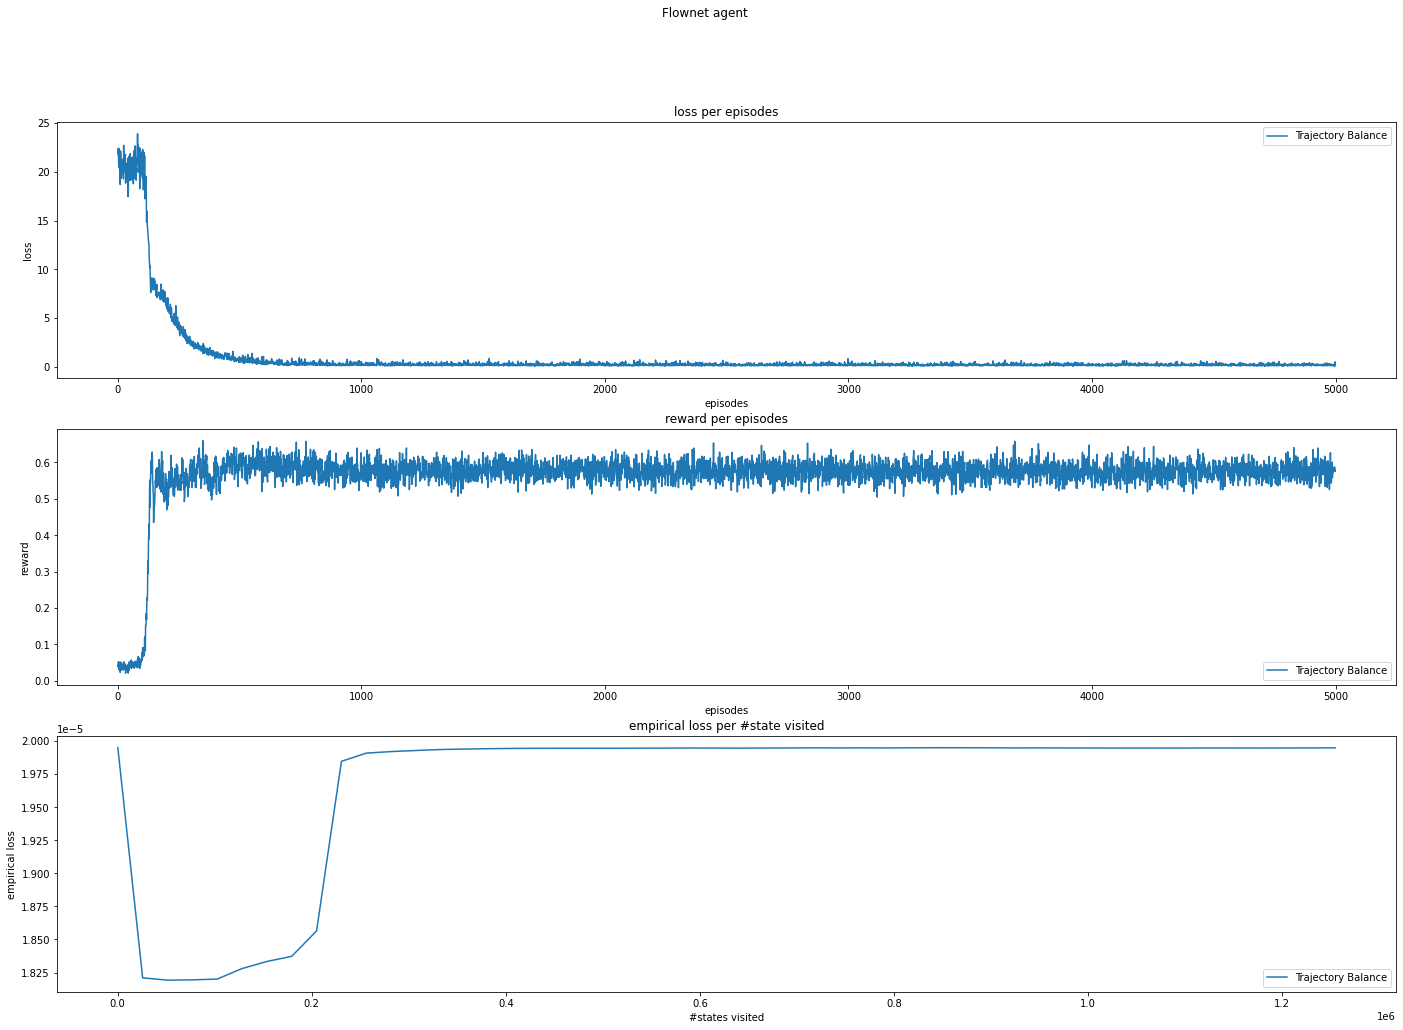

In [13]:
figsize=(6*4,4*4)
fig, (ax1, ax2, ax3)  = plt.subplots(3, 1, sharex=False, sharey=False, figsize = figsize)
fig.suptitle("Flownet agent")

## loss
xs_TB = list(range(len(losses_TB)))
ax1.plot(xs_TB, losses_TB, label="Trajectory Balance")
ax1.set(xlabel='episodes', ylabel='loss')
ax1.set_title('loss per episodes')
ax1.legend()

## rewards
ax2.plot(xs_TB, rewards_TB, label="Trajectory Balance")
ax2.set(xlabel='episodes', ylabel='reward')
ax2.set_title('reward per episodes')
ax2.legend()

## empirical loss
xs = [a[0] for a in l1log_TB]
emp_loss_TB = [a[1] for a in l1log_TB]
ax3.plot(xs, emp_loss_TB, label="Trajectory Balance")
ax3.set(xlabel='#states visited', ylabel='empirical loss')
ax3.set_title('empirical loss per #state visited')
ax3.legend()

# samples

In [14]:
samples = []
samples_R = []

for it in tqdm.trange(100):

    generated = torch.LongTensor(batch_size, max_len)  # upcoming output
    generated.fill_(params.pad_index)                  # fill upcoming ouput with <PAD>
    generated[:,0].fill_(params.bos_index)             # <BOS> (start token), initial state

    # Length of already generated sequences : 1 because of <BOS>
    #gen_len = (generated != params.pad_index).long().sum(dim=1)
    gen_len = torch.LongTensor(batch_size,).fill_(1) # (batch_size,)
    # 1 (True) if the generation of the sequence is not yet finished, 0 (False) otherwise
    unfinished_sents = gen_len.clone().fill_(1) # (batch_size,)
    # Length of already generated sequences : 1 because of <BOS>
    cur_len = 1 

    while cur_len < max_len:
        state = generated[:,:cur_len] + 0 # (bs, cur_len)
        with torch.no_grad():
            tensor = model(state.to(device), lengths=gen_len.to(device)) # (bs, cur_len, vocab_size)
        #scores = tensor[:,0] # (bs, vocab_size) : use last word for prediction
        scores = tensor.sum(dim=1) # (bs, vocab_size) 
        scores[:,pad_index] = -1e2 # we don't want to generate pad_token
        scores[:,eos_index] = -1e2 # if we don't want to generate eos_token : don't allow generation of sentences with differents lengths
        scores = scores.log_softmax(1)
        sample_temperature = 1
        probs = F.softmax(scores / sample_temperature, dim=1)
        #next_words = torch.distributions.categorical.Categorical(probs=probs).sample()
        next_words = torch.multinomial(probs, 1).squeeze(1)

        # update generations / lengths / finished sentences / current length
        generated[:,cur_len] = next_words.cpu() * unfinished_sents + params.pad_index * (1 - unfinished_sents)
        gen_len.add_(unfinished_sents) # add 1 to the length of the unfinished sentences
        unfinished_sents.mul_(next_words.cpu().ne(params.eos_index).long()) # as soon as we generate <EOS>, set unfinished_sents to 0
        cur_len = cur_len + 1
      
        # stop when there is a <EOS> in each sentence, or if we exceed the maximul length
        if unfinished_sents.max() == 0:
            break

    generated = generated.apply_(lambda index : 0 if index == pad_index or index == eos_index else index)
    #R = reward_function(generated, reward_coef, lambda_, beta).to(device)
    generated =  [float("".join([str(s_i) for s_i in s])) for s in generated.tolist()]
    R = reward_function22(generated, reward_coef, lambda_, beta).to(device) 

    samples.extend(generated)  
    samples_R.extend([r.item() for r in R.cpu()]) 

100%|██████████| 100/100 [00:01<00:00, 58.77it/s]


In [15]:
print(list(set(samples))[:50])

[8192.0, 817.0, 4627.0, 2089.0, 7210.0, 7211.0, 7212.0, 7213.0, 7214.0, 7215.0, 7216.0, 7219.0, 2100.0, 2101.0, 2102.0, 2103.0, 2104.0, 2105.0, 2106.0, 2107.0, 2108.0, 2110.0, 6720.0, 6721.0, 6722.0, 6723.0, 6724.0, 6725.0, 6726.0, 6727.0, 6729.0, 4210.0, 4211.0, 4212.0, 4213.0, 4214.0, 4215.0, 4216.0, 4217.0, 3890.0, 7291.0, 7292.0, 7293.0, 7294.0, 7295.0, 7296.0, 4219.0, 6272.0, 7299.0, 1672.0]


In [16]:
tmp = torch.tensor(samples_R)
100. * (tmp >= 0.5).sum() / len(tmp) 

tensor(70.4375)

In [17]:
tmp = torch.tensor(list(set(samples_R)))
topk_gen = tmp.topk(min(100, len(tmp)))
print(topk_gen.values), 100*(tmp >= topk_gen.values.max()).sum() / tmp.size(0)

tensor([1.0000e+00, 5.0000e-01, 2.5000e-01, 1.2500e-01, 6.2501e-02, 3.1251e-02,
        1.5626e-02, 7.8135e-03, 3.9072e-03, 1.9541e-03, 9.7756e-04, 4.8928e-04,
        2.4514e-04, 6.2035e-05, 8.6294e-06, 4.8147e-06, 2.9073e-06, 1.9537e-06,
        1.4768e-06, 1.2384e-06, 1.0149e-06, 1.0075e-06, 1.0037e-06, 1.0019e-06,
        1.0005e-06, 1.0000e-06, 1.0000e-06])


(None, tensor(3.7037))

In [18]:
tmp = torch.tensor(samples_R)
topk_gen = tmp.topk(min(100, len(tmp)))
print(topk_gen.values), 100*(tmp >= topk_gen.values.max()).sum() / tmp.size(0), 100*(tmp >= 0.5).sum() / tmp.size(0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


(None, tensor(33.8750), tensor(70.4375))

In [19]:
topk_modes = torch.tensor(all_rewards).topk(k=10)
topk_modes.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [20]:
modes = topk_modes.indices
#modes = torch.nonzero(torch.round(all_rewards) == 1.0, as_tuple=False).squeeze()
modes = torch.nonzero(torch.round(all_rewards) >= 0.7, as_tuple=False).squeeze()
print(modes)

tensor([    0,    81,   162,  ..., 99792, 99873, 99954])


In [21]:
total = len(samples)
good = 0
for g in samples :
    if g in modes : good+=1 
100. * good/total

33.875